In [1]:
from iGTP_Linear import *
from iGTP_model_modified_scvi_sample_final_update import *
from preprocess import *
from learning_utilies import *
import os 
import scanpy as sc
import pickle5 as pickle
from sklearn.manifold import TSNE
import numpy as np 

Global seed set to 0
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [361]:
model_list=os.listdir('./save_model/pbmc_IFN_filtered/')
model_list=[i for i in model_list if '.ipynb_checkpoints' not in i]
model_list=[i for i in model_list if 'mse' in i]
model_list=[i for i in model_list if 'GO' in i]
model_list=[i for i in model_list if 'batchbest' in i]
model_list.sort()

In [3]:
model_list

['GO_merged_PC_homo_v11mse_pos_uniform_15000batchbest_fold.pt']

In [4]:
file_list=os.listdir('./save_model/pbmc_IFN_filtered/processed_data')
file_list=[i for i in file_list if '.ipynb_checkpoints' not in i]
file_list=[i for i in file_list if 'GO' in i]
file_list=[i for i in file_list if 'mse' in i]
file_list=[i for i in file_list if 'batch' in i]
file_list.sort()

In [71]:
file_list

['GO_merged_PC_homo_v11mse_pos_uniform_15000batch.pkl']

In [5]:
task_file_path='./save_model/pbmc_IFN_filtered/processed_data/'+file_list[0]
with open(task_file_path, 'rb') as file:
    task_file = pickle.load(file)
args=task_file['args']
data_x_s=task_file['data_x_s']
mask_list_dict=task_file['mask_dict']
data=task_file['data']
TP_df=task_file['TP_df']
PPI_df=task_file['ppi_df_1']

In [6]:
args

{'tp_overlap_fraction': 0.1,
 'encoder_layer_list': [10370, 1500],
 'beta': 5e-05,
 'encoder_normal': 'batch',
 'init_type': 'pos_uniform',
 'recon_loss': 'mse',
 'drop_out': 0.2,
 'eps': 0.001,
 'cv_fold': 5,
 'learning_rate': 0.001,
 'learning_rate_weight_decay': 5.4e-05,
 'n_epochs': 500,
 'train_patience': 10,
 'test_patience': 10,
 'data_num_workers': 1,
 'save_fold': True,
 'save_best': True,
 'anneal_start': None,
 'anneal_time': None,
 'sc_data_path': '/home/iGTP/iGTP_data/pbmc_IFN_filtered.h5ad',
 'tp_file_path': '/home/iGTP/TP/GO_merged.gmt',
 'ppi_file_path': '/home/iGTP/ppi/PC_homo_v11.txt',
 'model_dir': './save_model/pbmc_IFN_filtered/',
 'vb_nu': 15000,
 'model_prefix': 'GO_merged_PC_homo_v11mse_pos_uniform_15000batch',
 'batch_size': 4000,
 'drop_last_batch': False,
 'device_nu': 1,
 'using_gpu': True,
 'z_sample': 1,
 'n_TP': 1296,
 'model_data_dir': './save_model/pbmc_IFN_filtered/processed_data/'}

In [7]:
mask_list_dict['TP_Gene_mask'].shape

(1296, 10370)

In [8]:
model=iGTP(args,mask_list_dict)
saved_state_dict = torch.load(args['model_dir']+model_list[0],map_location="cpu")
model.load_state_dict(saved_state_dict)
model.eval()
with torch.no_grad():
    z=model.encode_z(torch.tensor(data_x_s).float())
    ppi=model.encode_ppi(torch.tensor(data_x_s).float())

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
ppi.shape

(13672, 10370)

In [10]:
z.shape

(13672, 1296)

In [11]:
import pandas as pd
import numpy as np
import multiprocessing
from functools import partial
from tqdm import tqdm

In [12]:
tsne_1 = TSNE(n_components=2, random_state=42).fit_transform(z)
label_df=data.obs.reset_index()
label_df['dim_1']=tsne_1[:,0]
label_df['dim_2']=tsne_1[:,1]

In [33]:
help(model.compute_pair_bayes_factor)

Help on method compute_pair_bayes_factor in module iGTP_model_modified_scvi_sample_final_update:

compute_pair_bayes_factor(array, cell_inf, condiction_column, cell_type_column, stimulate_condiciton, control_condiciton, tsne, use_permutation=True, bays_eps=1e-08, m_permutation=5000) method of iGTP_model_modified_scvi_sample_final_update.iGTP instance



In [34]:
cell_inf_df=data.obs.copy()
cell_inf_df['cell_index']=range(len(cell_inf_df))
res=model.compute_pair_bayes_factor(z,cell_inf_df,'stim','cell.type','stim','ctrl',tsne_1,m_permutation=12000)
TP_df_b=pd.DataFrame(res)
TP_df_b['TP_name']=TP_df['TP_name'].values
TP_df_b['TP_gene']=TP_df['TP_gene'].values
TP_df_b['TP_index']=range(len(TP_df_b))

In [73]:
TP_df_b[TP_df_b.TP_name.str.contains('interferon')]

proba_m1  proba_m2  bayes_factor    scale1     scale2        mad  \
365    0.9862    0.0138      4.269190 -8.099439   4.957356  13.056806   
424    0.9856    0.0144      4.226022 -4.752307   9.292057  14.044337   
399    0.9827    0.0173      4.039597 -6.548478   9.575564  16.124037   
366    0.9791    0.0209      3.846884 -6.287043   8.103008  14.390020   
423    0.9455    0.0545      2.853513 -3.741006  10.432464  14.173434   
400    0.8099    0.1901      1.449360 -2.536253   5.227873   7.764120   

                              TP_name  \
365   BP_type_I_interferon_production   
424    BP_response_to_interferon_beta   
399  BP_response_to_type_I_interferon   
366    BP_interferon_gamma_production   
423   BP_response_to_interferon_alpha   
400   BP_response_to_interferon_gamma   

                                               TP_gene  TP_index     abs_b  
365  [TLR3, TRIM56, LILRB1, STAT6, POLR3B, CD14, DD...       365  4.269190  
424  [TLR3, HTRA2, IFITM2, PNPT1, PYHIN1, STAT1, IF...       424  4.226022  
399  [IRF4, USP18, ISG15, MAVS, IFITM2, IRF3, STAT2...       399  4.039597  
366  [TLR3, PGLYRP2, RIPK3, LILRB1, IL18, WNT5A, CD...       366  3.846884  
423  [IFITM2, PYHIN1, TPR, LAMP3, AXL, PDE12, GAS6,...       423  2.853513  
400  [TRIM31, TLR3, IRF4, PIAS1, IFITM2, IRF9, CCL2...       400  1.449360

In [74]:
TP_df_b['abs_b']=abs(TP_df_b.bayes_factor)
TP_df_b=TP_df_b.sort_values(by='abs_b',ascending=False)
TP_df_b_1=TP_df_b[(TP_df_b.abs_b>=4)&(TP_df_b['mad']>=3)]

In [75]:
TP_df_b_1

proba_m1  proba_m2  bayes_factor     scale1    scale2        mad  \
283    0.9881    0.0119      4.419245  -4.585403  7.921676  12.507079   
207    0.9878    0.0122      4.394043 -10.205760  7.846998  18.052738   
338    0.9870    0.0130      4.329720 -11.856461  6.289182  18.145706   
482    0.9868    0.0132      4.314250  -4.742313  8.801345  13.543662   
767    0.9863    0.0137      4.276564  -9.697343  6.030765  15.728080   
365    0.9862    0.0138      4.269190  -8.099439  4.957356  13.056806   
738    0.9856    0.0144      4.226022  -9.528016  8.506817  18.034798   
424    0.9856    0.0144      4.226022  -4.752307  9.292057  14.044337   
440    0.9844    0.0156      4.144761  -5.168978  7.026393  12.195354   
513    0.9842    0.0158      4.131819  -5.735661  6.392838  12.128454   
496    0.9831    0.0169      4.063397  -4.273507  5.560028   9.833533   
49     0.9829    0.0171      4.051428  -2.684903  6.956867   9.641738   
399    0.9827    0.0173      4.039597  -6.548478  9.575564  16.124037   

                                               TP_name  \
283                                BP_viral_life_cycle   
207                               BP_response_to_virus   
338         BP_negative_regulation_of_defense_response   
482                               BP_response_to_dsRNA   
767              BP_defense_response_to_other_organism   
365                    BP_type_I_interferon_production   
738  BP_pyrimidine_containing_compound_metabolic_pr...   
424                     BP_response_to_interferon_beta   
440        BP_signal_transduction_in_absence_of_ligand   
513            BP_regulation_of_innate_immune_response   
496            BP_regulation_of_multi_organism_process   
49     BP_negative_regulation_of_immune_system_process   
399                   BP_response_to_type_I_interferon   

                                               TP_gene  TP_index     abs_b  
283  [TRIM31, FCN1, ITGB3, UBP1, VPS37A, IFITM2, PA...       283  4.419245  
207  [TLR3, CYP1A1, RNASE6, LCN2, IFITM2, IKBKG, SP...       207  4.394043  
338  [ADCY7, PDCD4, NDFIP1, LILRB1, CR1, TNFAIP8L2,...       338  4.329720  
482  [NPM1, TLR3, FLOT1, MAPK3, IRAK3, MAVS, IRF3, ...       482  4.314250  
767  [TRIM56, LILRB1, PRF1, IFI27, PMAIP1, CLEC7A, ...       767  4.276564  
365  [TLR3, TRIM56, LILRB1, STAT6, POLR3B, CD14, DD...       365  4.269190  
738  [NMRK1, TDG, SMUG1, AGPAT1, AGPAT5, CMPK2, TBP...       738  4.226022  
424  [TLR3, HTRA2, IFITM2, PNPT1, PYHIN1, STAT1, IF...       424  4.226022  
440  [INHBA, FYN, HTRA2, LCN2, BAG3, PPP2R1A, BCL2L...       440  4.144761  
513  [MAP2K6, LYN, TLR3, IRF4, FCN1, PGLYRP2, IRAK2...       513  4.131819  
496  [TRIM31, FCN1, SP1, CXCL6, PPP2R3C, BMP6, LY96...       496  4.063397  
49   [LYN, LAG3, MERTK, LILRB1, AKT1, TAPBPL, MIF, ...        49  4.051428  
399  [IRF4, USP18, ISG15, MAVS, IFITM2, IRF3, STAT2...       399  4.039597

In [76]:
se_g=[]
for i in TP_df_b_1['TP_gene']:
    for j in i:
        se_g.append(j)
se_g=list(set(se_g))

In [78]:
len(se_g)

1153

In [81]:
gene_weight=saved_state_dict['decoder_Gene_Gene.0.weight'].cpu().detach().numpy()
gene_bias=saved_state_dict['decoder_Gene_Gene.0.bias'].cpu().detach().numpy()
#ori_ppi_df=pd.read_csv('/home/iGTP/ppi/PC_homo_v11.txt',sep='\t')
#new_PPI_df=PPI_df.merge(ori_ppi_df)
new_PPI_df=PPI_df[(PPI_df.gene1.isin(se_g))&(PPI_df.gene2.isin(se_g))&(PPI_df.gene1!=PPI_df.gene2)]
new_PPI_df['PPI']=new_PPI_df['gene1']+'-'+new_PPI_df['gene2']
new_PPI_df['PPI_index']=range(len(new_PPI_df))

/tmp/ipykernel_109408/2764198122.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_PPI_df['PPI']=new_PPI_df['gene1']+'-'+new_PPI_df['gene2']
/tmp/ipykernel_109408/2764198122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_PPI_df['PPI_index']=range(len(new_PPI_df))


In [84]:
new_PPI_df[new_PPI_df.gene1=='GATA3']

gene1   gene2  gene_1_index  gene_2_index           PPI  PPI_index
243251  GATA3  MAPK14          5367          3452  GATA3-MAPK14      10789
243265  GATA3    RARA          5367          8576    GATA3-RARA      10790
243254  GATA3    MED1          5367          8556    GATA3-MED1      10791
243258  GATA3     MYC          5367          4890     GATA3-MYC      10792
243277  GATA3   STAT1          5367          1625   GATA3-STAT1      10793
214307  GATA3    ETS1          5367          6329    GATA3-ETS1      10794
243291  GATA3    VAPB          5367          9306    GATA3-VAPB      10795
243285  GATA3   TGFB1          5367          9791   GATA3-TGFB1      10796
243281  GATA3   TBX21          5367          8657   GATA3-TBX21      10797
243280  GATA3    TAL1          5367           362    GATA3-TAL1      10798
243274  GATA3     SP1          5367          6590     GATA3-SP1      10799
226687  GATA3   FBXW7          5367          2742   GATA3-FBXW7      10800
205667  GATA3   EP300          5367         10198   GATA3-EP300      10801
235581  GATA3   FOXP3          5367          4372   GATA3-FOXP3      10802
243234  GATA3   HDAC1          5367           238   GATA3-HDAC1      10803

In [83]:
new_PPI_df

gene1   gene2  gene_1_index  gene_2_index            PPI  PPI_index
297914   ISG15  HSPA1A             4          3382   ISG15-HSPA1A          0
301198   ISG15   HSPD1             4          1636    ISG15-HSPD1          1
300686   ISG15   HSPB1             4          3984    ISG15-HSPB1          2
299850   ISG15   HSPA8             4          6306    ISG15-HSPA8          3
122362   ISG15    CHD1             4          2986     ISG15-CHD1          4
...        ...     ...           ...           ...            ...        ...
12116   ADARB1    WWP2         10357          8168    ADARB1-WWP2      21737
12103   ADARB1   PRKRA         10357          1597   ADARB1-PRKRA      21738
12101   ADARB1   PNPT1         10357          1271   ADARB1-PNPT1      21739
12100   ADARB1    PIN1         10357          9507    ADARB1-PIN1      21740
12111   ADARB1  TARBP2         10357          6593  ADARB1-TARBP2      21741

[21742 rows x 6 columns]

In [85]:
def process_chunk(chunk, gene_weight, label_df):

    for i, row in tqdm(chunk.iterrows()):
        gene_1_index = row['gene_1_index']
        gene_2_index = row['gene_2_index']
        PPI=row['PPI']
        specific_sites1 = [(gene_1_index, gene_2_index)]
        specific_sites2 = [(gene_2_index, gene_1_index)]
        mask1 = np.zeros_like(gene_weight, dtype=bool)
        for site in specific_sites1:
            mask1[site] = True
        gene_weight1 = np.where(mask1, gene_weight, 0)

        mask2 = np.zeros_like(gene_weight, dtype=bool)
        for site in specific_sites2:
            mask2[site] = True
        gene_weight2 = np.where(mask2, gene_weight, 0)
        value1 = np.sum(np.matmul(ppi, gene_weight1.T), axis=1)
        value2 = np.sum(np.matmul(ppi, gene_weight2.T), axis=1)
        temp_df = pd.DataFrame(label_df['index'].values, columns=['cell'])
        temp_df['value1'] = value1
        temp_df['value2'] = value2
        temp_df[PPI] = np.where(temp_df['value1'] > temp_df['value2'], temp_df['value1'], temp_df['value2'])
        temp_df=temp_df[['cell',PPI]]
        temp_df.to_csv('./PPI/PBMC/'+PPI+'.csv',index=False)
        

In [86]:
def parallel_process(df, func, num_processes, gene_weight, label_df):
    chunks = np.array_split(df, num_processes)  # Split DataFrame into chunks
    with multiprocessing.Pool(processes=num_processes) as pool:
        pool.map(partial(func, gene_weight=gene_weight, label_df=label_df), chunks)

In [87]:
num_processes = 40

# Parallel processing
parallel_process(new_PPI_df, process_chunk, num_processes, gene_weight, label_df)


543it [7:11:40, 47.70s/it]
543it [7:26:36, 49.35s/it]
543it [7:28:35, 49.57s/it]
544it [7:29:21, 49.56s/it]
543it [7:26:41, 49.36s/it]
544it [7:39:31, 50.68s/it]
543it [7:46:51, 51.59s/it]
543it [7:44:35, 51.34s/it]
544it [7:49:28, 51.78s/it]
544it [7:52:49, 52.15s/it]
543it [7:49:41, 51.90s/it]
544it [7:51:59, 52.06s/it]
544it [7:55:02, 52.39s/it]
543it [7:54:22, 52.42s/it]
543it [7:54:41, 52.45s/it]
544it [8:00:24, 52.99s/it]
543it [7:58:51, 52.91s/it]
543it [8:00:14, 53.07s/it]
544it [8:03:51, 53.37s/it]
543it [8:01:12, 53.17s/it]
544it [8:03:20, 53.31s/it]
544it [8:04:59, 53.49s/it]
544it [8:05:02, 53.50s/it]
544it [8:05:31, 53.55s/it]
544it [8:06:18, 53.64s/it]
544it [8:05:52, 53.59s/it]
543it [8:05:04, 53.60s/it]
544it [8:09:06, 53.95s/it]
544it [8:07:05, 53.72s/it]
543it [8:05:32, 53.65s/it]
544it [8:10:17, 54.08s/it]
544it [8:09:57, 54.04s/it]
543it [8:06:29, 53.76s/it]
544it [8:10:37, 54.11s/it]
544it [8:09:48, 54.02s/it]
543it [8:06:17, 53.73s/it]
544it [8:10:46, 54.13s/it]
5

In [88]:
new_PPI_df.head()

gene1   gene2  gene_1_index  gene_2_index           PPI  PPI_index
297914  ISG15  HSPA1A             4          3382  ISG15-HSPA1A          0
301198  ISG15   HSPD1             4          1636   ISG15-HSPD1          1
300686  ISG15   HSPB1             4          3984   ISG15-HSPB1          2
299850  ISG15   HSPA8             4          6306   ISG15-HSPA8          3
122362  ISG15    CHD1             4          2986    ISG15-CHD1          4

In [95]:
z_ppi=[]
for i in tqdm(range(len(new_PPI_df))):
    PPI=new_PPI_df.PPI.values[i]
    temp_df=pd.read_csv('./PPI/PBMC/'+PPI+'.csv')
    z_ppi.append(temp_df[PPI].values)
z_ppi=np.array(z_ppi).T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 21742/21742 [02:27<00:00, 147.18it/s]


In [97]:
print(z_ppi.shape)
print(z.shape)

(13672, 21742)
(13672, 1296)


In [104]:
res=model.compute_pair_bayes_factor(z_ppi,cell_inf_df,'stim','cell.type','stim','ctrl',tsne_1)
PPI_df_b=pd.DataFrame(res)

In [106]:
PPI_df_b=pd.DataFrame(res)
PPI_df_b['gene_1']=new_PPI_df['gene1'].values
PPI_df_b['gene_2']=new_PPI_df['gene2'].values
PPI_df_b['Interaction']=new_PPI_df['PPI'].values
PPI_df_b['PPI_index']=range(len(PPI_df_b))

In [115]:
PPI_df_b[(PPI_df_b['mad']!=0)].sort_values(by='mad',ascending=False).head(n=60)

proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
391      0.9886    0.0114      4.462676  0.154701  2.334227  2.179525    IFI6   
15714    0.9886    0.0114      4.462676  0.154701  2.334227  2.179525    CIB1   
15707    0.9490    0.0510      2.923583  0.596088  1.926268  1.330179   ISG20   
18809    0.9490    0.0510      2.923583  0.596088  1.926268  1.330179     SRC   
14087    0.9534    0.0466      3.018434  0.128725  1.176499  1.047774    OASL   
6096     0.9534    0.0466      3.018434  0.128725  1.176499  1.047774    CD14   
1775     0.9852    0.0148      4.198217  0.055236  1.046893  0.991658    DHX9   
1050     0.9852    0.0148      4.198217  0.055236  1.046893  0.991658  IFI44L   
28       0.9860    0.0140      4.254598  0.049832  0.960992  0.911160   ISG15   
21622    0.9860    0.0140      4.254598  0.049832  0.960992  0.911160     MX1   
14071    0.9646    0.0354      3.305001  0.146205  0.972010  0.825805    OAS1   
6684     0.9646    0.0354      3.305001  0.146205  0.972010  0.825805  TRIM27   
8        0.9858    0.0142      4.240211  0.044839  0.867088  0.822249   ISG15   
11131    0.9858    0.0142      4.240211  0.044839  0.867088  0.822249   IFIT1   
11117    0.9832    0.0168      4.069433  0.041282  0.841420  0.800138   IFIT3   
11133    0.9832    0.0168      4.069433  0.041282  0.841420  0.800138   IFIT1   
10073    0.9810    0.0190      3.944133  0.126225  0.924890  0.798665   IFNB1   
25       0.9810    0.0190      3.944133  0.126225  0.924890  0.798665   ISG15   
19950    0.9490    0.0510      2.923583  0.354602  1.145902  0.791300    BST2   
18755    0.9490    0.0510      2.923583  0.354602  1.145902  0.791300     SRC   
11104    0.9838    0.0162      4.106411  0.042760  0.795537  0.752777   IFIT2   
11128    0.9838    0.0162      4.106411  0.042760  0.795537  0.752777   IFIT1   
5156     0.5066    0.4934      0.026402  0.044830  0.762908  0.718078  CXCL10   
1684     0.5066    0.4934      0.026402  0.044830  0.762908  0.718078    XCL1   
40       0.9858    0.0142      4.240211  0.038251  0.742236  0.703984   ISG15   
5187     0.9858    0.0142      4.240211  0.038251  0.742236  0.703984   HERC5   
15529    0.9802    0.0198      3.902074  0.053894  0.698251  0.644358   PIAS1   
1046     0.9802    0.0198      3.902074  0.053894  0.698251  0.644358  IFI44L   
18459    0.9810    0.0190      3.944133  0.048476  0.685773  0.637297    MAVS   
14076    0.9810    0.0190      3.944133  0.048476  0.685773  0.637297    OAS3   
11517    0.9870    0.0130      4.329720  0.046662  0.673140  0.626478    IRF7   
12460    0.9870    0.0130      4.329720  0.046662  0.673140  0.626478    FADD   
7563     0.8724    0.1276      1.922348  0.254074  0.849614  0.595540     FYN   
11471    0.8724    0.1276      1.922348  0.254074  0.849614  0.595540  IFITM3   
11123    0.9858    0.0142      4.240211  0.031590  0.619742  0.588152   IFIT3   
19       0.9858    0.0142      4.240211  0.031590  0.619742  0.588152   ISG15   
20594    0.9454    0.0546      2.851574  0.021548  0.593727  0.572179    IRF3   
5184     0.9454    0.0546      2.851574  0.021548  0.593727  0.572179   HERC5   
15708    0.9520    0.0480      2.987364  0.281689  0.853269  0.571580   ISG20   
12713    0.9520    0.0480      2.987364  0.281689  0.853269  0.571580   NCAM1   
11470    0.4182    0.5818     -0.330167  0.133847  0.691968  0.558121  IFITM3   
403      0.4182    0.5818     -0.330167  0.133847  0.691968  0.558121   PTAFR   
15527    0.9814    0.0186      3.965818  0.046093  0.597185  0.551092   PIAS1   
21629    0.9814    0.0186      3.965818  0.046093  0.597185  0.551092     MX1   
6703     0.9646    0.0354      3.305001  0.097311  0.646947  0.549636  TRIM27   
11940    0.9646    0.0354      3.305001  0.097311  0.646947  0.549636  UBE2L6   
20583    0.9454    0.0546      2.851574  0.019883  0.547842  0.527959    IRF3   
5154     0.9454    0.0546      2.851574  0.019883  0.547842  0.527959  CXCL10   
6        0.9858    0.0142      4.24021

In [98]:
tSNE_folder='./fig_2_result/tSNE/'
tSNE_figure_folder='./fig_2_result/tSNE_figure/'
embedding_folder='./fig_2_result/z_embedding/'
TP_deg_folder='./fig_2_result/TP_deg/'
TP_deg_figure_folder='./fig_2_result/TP_deg_figure/'
PPI_deg_folder='./fig_2_result/PPI_deg/'
PPI_deg_figure_folder='./fig_2_result/PPI_deg_figure/'

In [99]:
if not os.path.exists(tSNE_folder):
    # Create the directory if it doesn't exist
    os.mkdir(tSNE_folder)
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
    
if not os.path.exists(tSNE_figure_folder):
    # Create the directory if it doesn't exist
    os.mkdir(tSNE_figure_folder)
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(embedding_folder):
    # Create the directory if it doesn't exist
    os.mkdir(embedding_folder)
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(TP_deg_folder):
    # Create the directory if it doesn't exist
    os.mkdir(TP_deg_folder)
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(TP_deg_figure_folder):
    # Create the directory if it doesn't exist
    os.mkdir(TP_deg_figure_folder)
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(PPI_deg_folder):
    # Create the directory if it doesn't exist
    os.mkdir(PPI_deg_folder)
    print("Directory created successfully.")
else:
    print("Directory already exists.")

if not os.path.exists(PPI_deg_figure_folder):
    # Create the directory if it doesn't exist
    os.mkdir(PPI_deg_figure_folder)
    print("Directory created successfully.")
else:
    print("Directory already exists.")

Directory created successfully.
Directory created successfully.
Directory created successfully.
Directory created successfully.
Directory created successfully.
Directory created successfully.
Directory created successfully.


In [100]:
if not os.path.exists(TP_deg_folder+'whole'):
    # Create the directory if it doesn't exist
    os.mkdir(TP_deg_folder+'whole')
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(TP_deg_folder+'cell_type'):
    
    # Create the directory if it doesn't exist
    os.mkdir(TP_deg_folder+'cell_type')
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(PPI_deg_folder+'whole'):
    
    # Create the directory if it doesn't exist
    os.mkdir(PPI_deg_folder+'whole')
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(PPI_deg_folder+'cell_type'):
    
    # Create the directory if it doesn't exist
    os.mkdir(PPI_deg_folder+'cell_type')
    print("Directory created successfully.")
else:
    print("Directory already exists.")

Directory created successfully.
Directory created successfully.
Directory created successfully.
Directory created successfully.


In [101]:
if not os.path.exists(embedding_folder+'whole_z'):
    # Create the directory if it doesn't exist
    os.mkdir(embedding_folder+'whole_z')
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(embedding_folder+'Z_TP'):
    
    # Create the directory if it doesn't exist
    os.mkdir(embedding_folder+'Z_TP')
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(embedding_folder+'Z_PPI'):
    
    # Create the directory if it doesn't exist
    os.mkdir(embedding_folder+'Z_PPI')
    print("Directory created successfully.")
else:
    print("Directory already exists.")

Directory created successfully.
Directory created successfully.
Directory created successfully.


In [102]:
if not os.path.exists(tSNE_figure_folder+'pbmc_stimulate'):
    # Create the directory if it doesn't exist
    os.mkdir(tSNE_figure_folder+'pbmc_stimulate')
    print("Directory created successfully.")
else:
    print("Directory already exists.")

if not os.path.exists(tSNE_figure_folder+'pbmc_cell_type'):
    # Create the directory if it doesn't exist
    os.mkdir(tSNE_figure_folder+'pbmc_cell_type')
    print("Directory created successfully.")
else:
    print("Directory already exists.")

    
if not os.path.exists(tSNE_figure_folder+'pbmc_pathway'):
    # Create the directory if it doesn't exist
    os.mkdir(tSNE_figure_folder+'pbmc_pathway')
    print("Directory created successfully.")
else:
    print("Directory already exists.")
    
if not os.path.exists(tSNE_figure_folder+'pbmc_ppi'):
    # Create the directory if it doesn't exist
    os.mkdir(tSNE_figure_folder+'pbmc_ppi')
    print("Directory created successfully.")
else:
    print("Directory already exists.")

Directory created successfully.
Directory created successfully.
Directory created successfully.
Directory created successfully.


In [103]:
args['model_prefix']

'GO_merged_PC_homo_v11mse_pos_uniform_15000batch'

In [130]:
model_data_file=embedding_folder+'whole_z/'+args['model_prefix']+'_pbmc_ifn_z.pkl'
with open(model_data_file, 'wb') as file:
    pickle.dump(z, file)
        
 
        
     # dump Z_PPI
model_data_file=embedding_folder+'Z_PPI/'+args['model_prefix']+'_pbmc_ifn_z.pkl'
with open(model_data_file, 'wb') as file:
    pickle.dump(z_ppi, file)

In [141]:
from adjustText import adjust_text
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [339]:
def plot_dfe(dfe_res,
             pathway_list,
             sig_lvl,
             lfc_lvl,
             to_plot=None,
             metric='mad',
             figsize=[12,5],
             s=10,
             fontsize=10,
             textsize=8,
             title=False,
             save=False):
    """
    Plot Differential Factor Expression results.
    Args:
        dfe_res (dict): dictionary with differential factor analysis results from VAE.
        pathway_list (list): list with name of factors
        sig_lvl (float): log_e(BF) threshold for significance.
        lfc_lvl (float): threshold for metric significance level (MAD or LFC).
        to_plot (dict): subset of factors to annotate on plot. If None, defaults to all significant (sig_lvl, lfc_lvl).
        metric (str): Metric to use for Y-axis. 'mad' or 'lfc' (default:'mad').
        figsize (tuple): figure size.
        s (int): size of dots for scatter.
        fontsize (int): size of text on axes.
        textsize (int): size of text for annotation on plot.
        title (str): plot title (optional).
        save (str): path to save figure (optional).
    """
    # Init plot
    plt.figure(figsize=figsize)
    xlim_v = np.abs(dfe_res['bayes_factor']).max() + 0.5
    ylim_v = dfe_res[metric].max()+0.5

    idx_sig = np.arange(len(dfe_res['bayes_factor']))[(np.abs(dfe_res['bayes_factor'])>sig_lvl) & (np.abs(dfe_res[metric])>lfc_lvl)]
    plt.scatter(dfe_res['bayes_factor'], dfe_res[metric], color='darkgrey', s=s, alpha=0.8, linewidth=0)
    #plt.scatter(dfe_res['bayes_factor'][dfe_res['s_values'] <= 0.1], dfe_res[metric][dfe_res['s_values'] <= 0.1], color='black', s=5, alpha=1)
    plt.scatter(dfe_res['bayes_factor'][idx_sig], dfe_res[metric][idx_sig],marker='*', color='salmon', s=s*2, linewidth=0)
    plt.vlines(x=-sig_lvl, ymin=-0.5, ymax=ylim_v, color='darkgreen', linestyles='--', linewidth=2., alpha=0.3)
    plt.vlines(x=sig_lvl, ymin=-0.5, ymax=ylim_v, color='darkgreen', linestyles='--', linewidth=2., alpha=0.3)
    plt.hlines(y=lfc_lvl, xmin=-xlim_v, xmax=xlim_v, color='darkcyan', linestyles='--', linewidth=2., alpha=0.3)
    texts = []
    
    if to_plot is None:
        for i in idx_sig:
            name = pathway_list[i]
            x = dfe_res['bayes_factor'][i]
            y = dfe_res[metric][i]
            texts.append(plt.text(x=x, y=y, s=name, fontdict={'size':textsize}))
    else:
        idx_plot = [(pathway_list.index(f),to_plot[f]) for f in to_plot]
        for i in idx_plot:
            name = i[1]
            x = dfe_res['bayes_factor'][i[0]]
            y = dfe_res[metric][i[0]]
            #if y < 5.5:
            texts.append(plt.text(x=x, y=y, s=name, fontdict={'size':textsize}))
    #print(texts)        
    # Cosmetics
    plt.xlabel(r'$\log_e$(Bayes factor)', fontsize=fontsize)
    if metric == 'mad':
        plt.ylabel('MAD', fontsize=fontsize)
    else:
        plt.ylabel(r'$\log{|(FC_{z})|}$', fontsize=fontsize)
    plt.ylim([0,ylim_v])
    plt.xlim([-xlim_v,xlim_v])
    if title:
        plt.title(title+'(|K|>%.1f)'%(sig_lvl))
    adjust_text(texts,only_move={'text':'xy', 'arrows':'xy' ,'static':'xy', 'explode':'xy', 'pull':'xy'},arrowprops=dict(arrowstyle="-", color='k', lw=1))
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    #plt.grid()
    #adjust_text(texts)
    if save:
        plt.savefig(save, format='pdf', dpi=150, bbox_inches='tight')
    plt.show()

In [340]:
z_tp=z.copy()
cell_inf_df=data.obs.copy()
cell_inf_df['cell_index']=range(len(cell_inf_df))
res=model.compute_pair_bayes_factor(z_tp,cell_inf_df,'stim','cell.type','stim','ctrl',tsne_1)
TP_df_b=pd.DataFrame(res)
TP_df_b['TP_name']=TP_df['TP_name'].values
TP_df_b['TP_index']=range(len(TP_df_b))
TP_df_b.to_csv(TP_deg_folder+'whole'+'/'+args['model_prefix']+'_pbmc_ifn.csv',index=False)
#print(TP_df_b.sort_values(by='mad').tail(n=30))  
temp_df=TP_df_b[abs(TP_df_b.bayes_factor)>=3]
temp_df=temp_df[temp_df['mad']>=6]
temp_df['new_tp_name']=[ i.replace('_',' ').split('%WikiPathways')[0].title() for i in temp_df['TP_name']]
string_list = ['Interferon', 'Virus']
temp_df= temp_df[temp_df['new_tp_name'].str.contains('|'.join(string_list))]
#print(len(temp_df))
new_all_df_dict={}
for j in range(len(temp_df)):
    new_all_df_dict[temp_df['TP_name'].values[j]]=temp_df['new_tp_name'].values[j]
print( "TP volcano plot")


TP volcano plot


In [341]:
new_all_df_dict

{'BP_response_to_virus': 'Bp Response To Virus',
 'BP_type_I_interferon_production': 'Bp Type I Interferon Production',
 'BP_interferon_gamma_production': 'Bp Interferon Gamma Production',
 'BP_response_to_type_I_interferon': 'Bp Response To Type I Interferon',
 'BP_response_to_interferon_beta': 'Bp Response To Interferon Beta'}

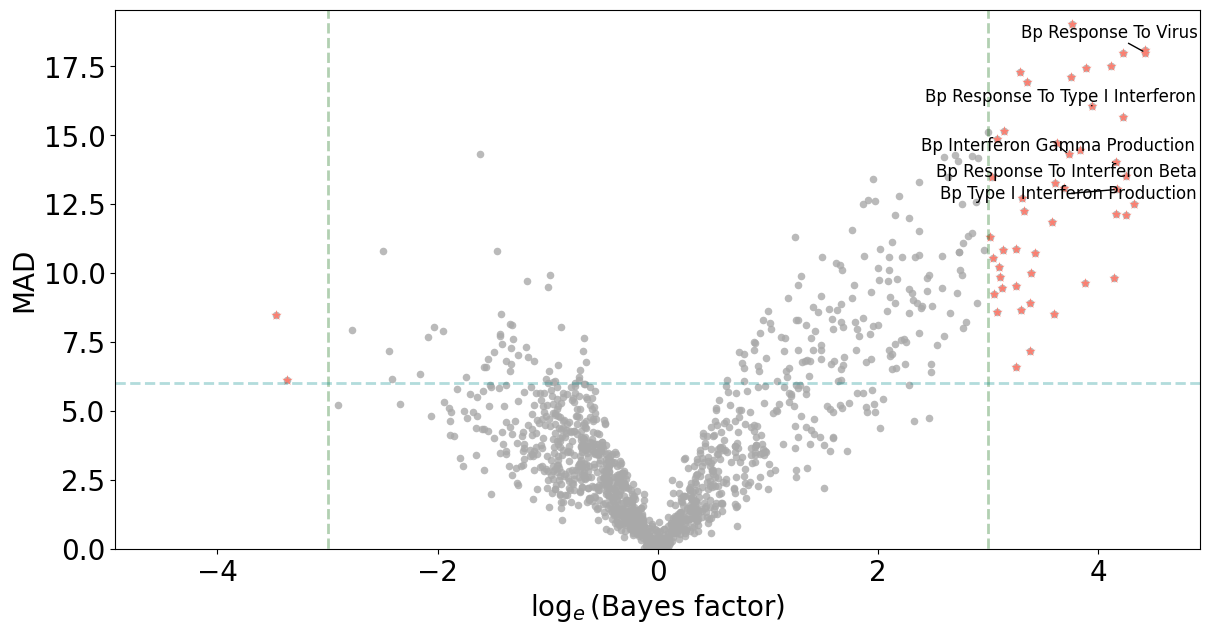

In [342]:
save_path=TP_deg_figure_folder+'/'+file_list[0].replace('.pkl','')+'pos.pdf'
plot_dfe(res,
         sig_lvl=3,
         pathway_list=list(TP_df_b['TP_name'].values),
         lfc_lvl=6,
         to_plot=new_all_df_dict,
         figsize=[14,7],
         s=30,
         fontsize=20,
         textsize=12,
    save=save_path)


In [359]:
label_df.to_csv('./fig_2_result/pbmc_label_df.csv',index=False)

In [358]:
tsne_1

array([[ 17.641476, -51.108845],
       [ 38.913776, -55.918583],
       [ 20.53302 , -51.8211  ],
       ...,
       [-51.11684 ,   8.763008],
       [ 38.743347,   8.934555],
       [ 56.974056,  24.450974]], dtype=float32)

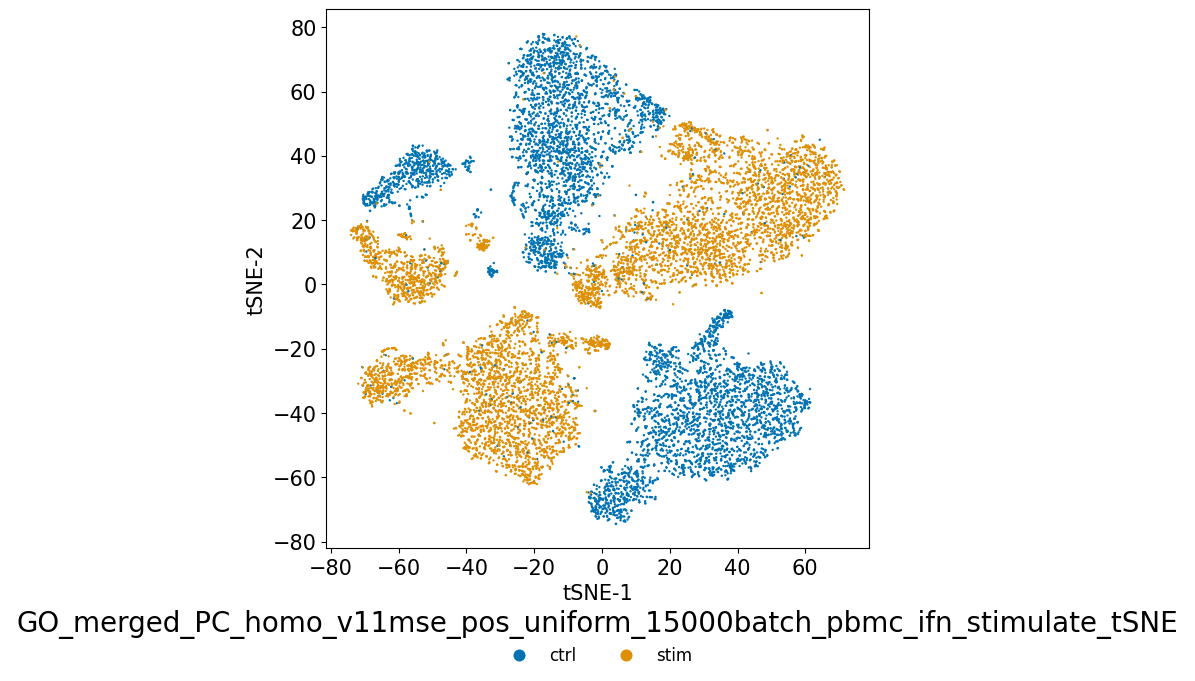

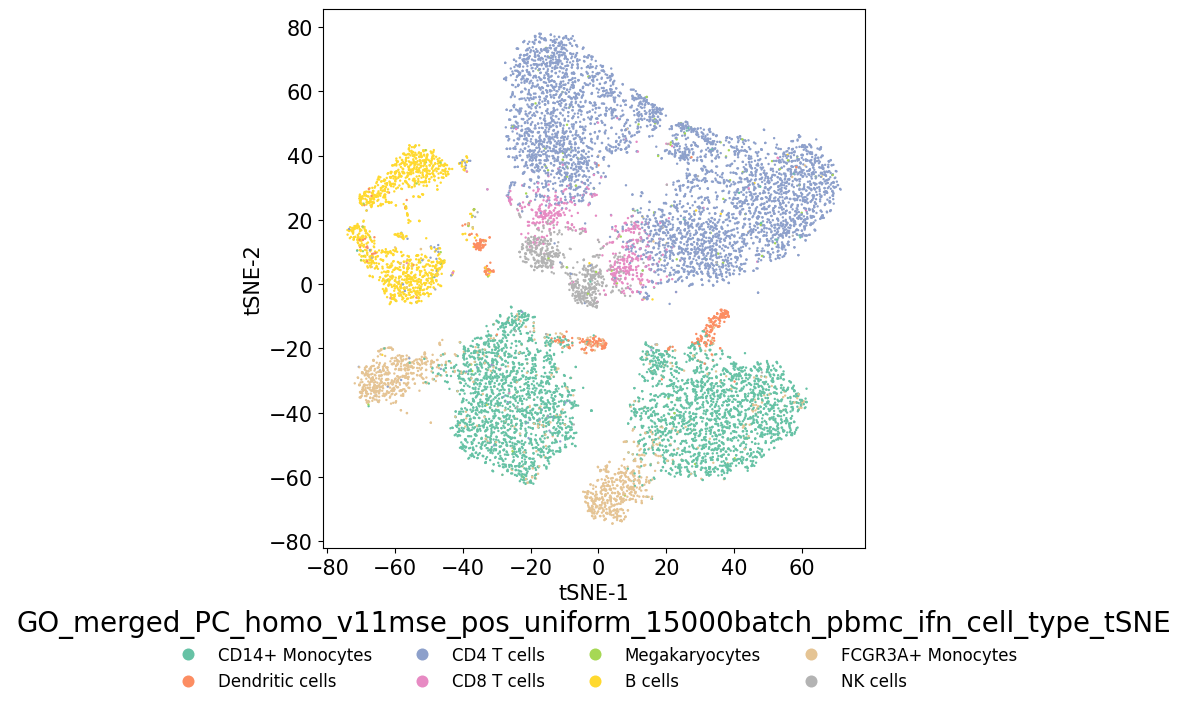

      proba_m1  proba_m2  bayes_factor     scale1     scale2        mad  \
687     0.9160    0.0840      2.389199 -11.289503   2.053190  13.342705   
697     0.9334    0.0666      2.640129 -12.491861   0.868832  13.360675   
778     0.9754    0.0246      3.680101  -5.124495   8.360817  13.485311   
482     0.9840    0.0160      4.119037  -4.710429   8.786130  13.496593   
1084    0.8758    0.1242      1.953245 -11.143359   2.458182  13.601556   
1237    0.9596    0.0404      3.167687 -13.422338   0.274006  13.696336   
1250    0.1754    0.8246     -1.547829  -7.711051 -21.729765  14.018692   
233     0.9354    0.0646      2.672760 -11.852192   2.192317  14.044498   
424     0.9860    0.0140      4.254598  -4.744543   9.326457  14.070993   
423     0.9466    0.0534      2.875066  -3.778110  10.497462  14.275574   
119     0.9348    0.0652      2.662873 -14.326316  -0.032999  14.293299   
366     0.9800    0.0200      3.891820  -6.307602   8.012788  14.320375   
793     0.9410    0.0590 

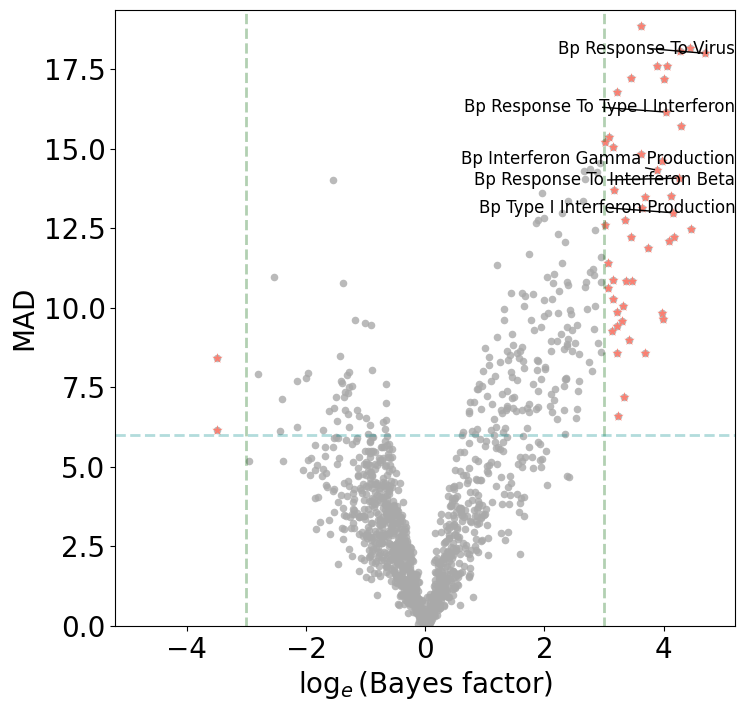

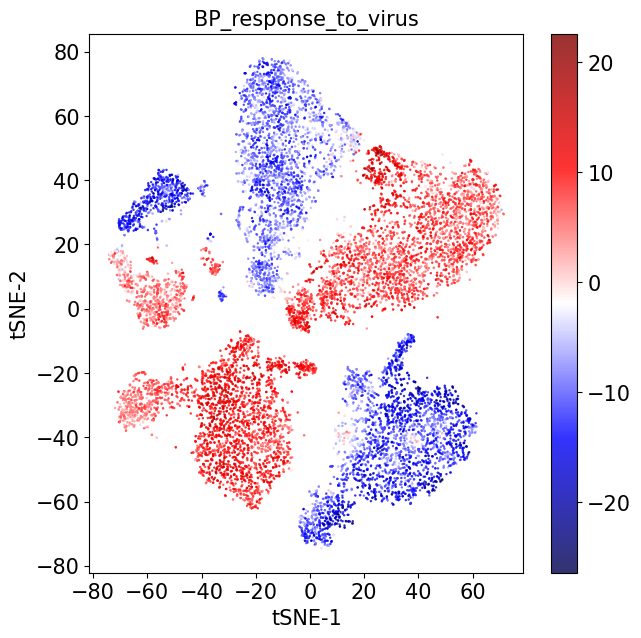

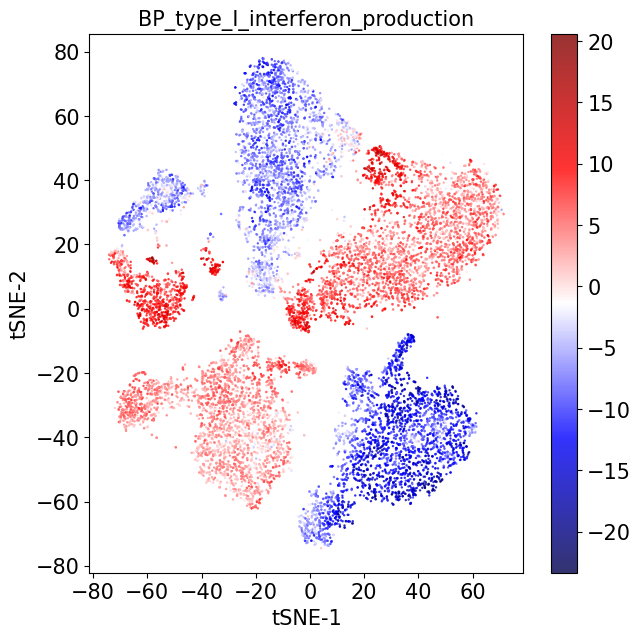

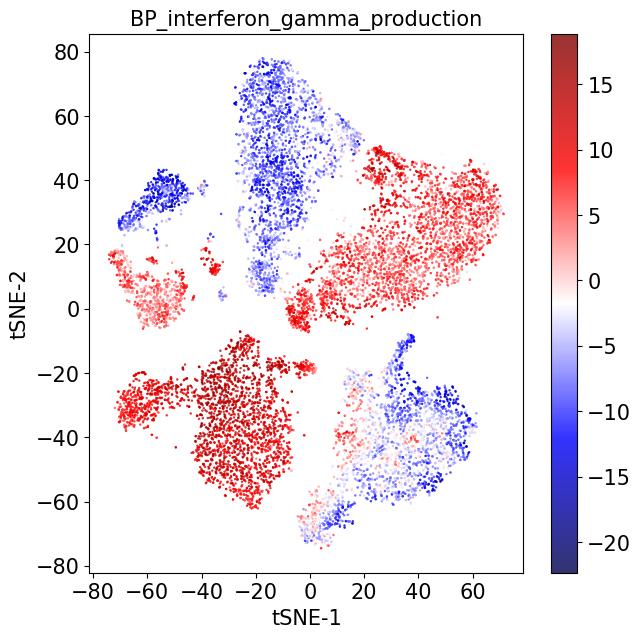

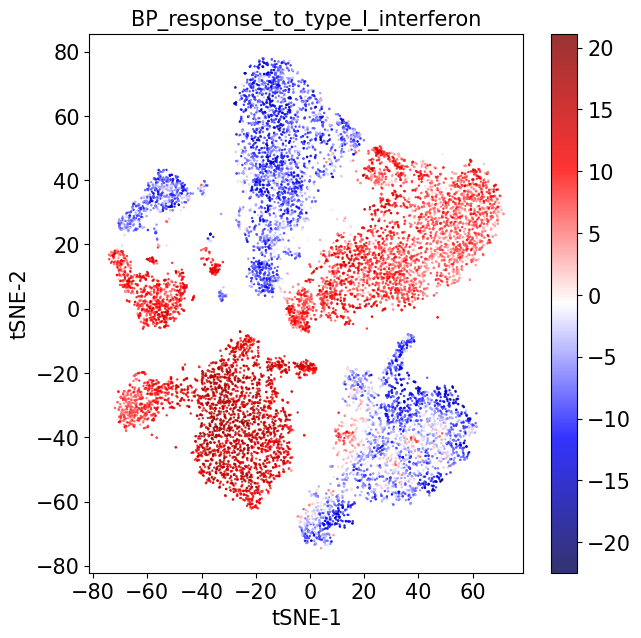

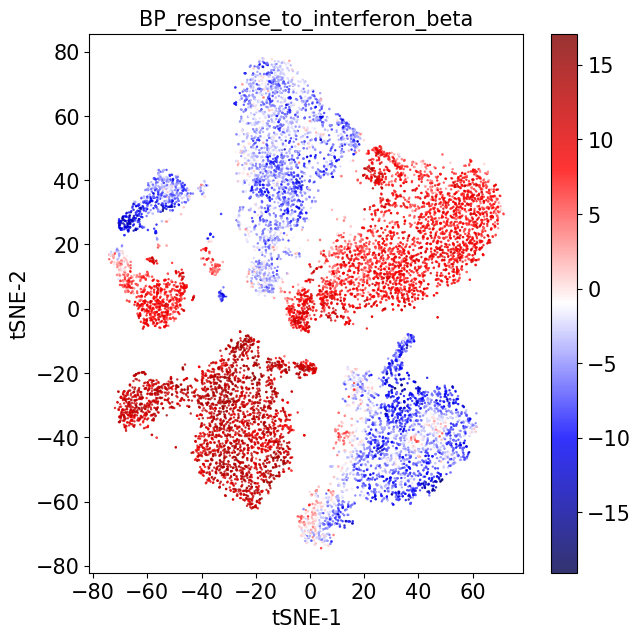

/tmp/ipykernel_109408/2651437865.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))
/tmp/ipykernel_109408/2651437865.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

CD14+ Monocytes
      proba_m1  proba_m2  bayes_factor     scale1     scale2        mad  \
1161    0.9948    0.0052      5.253881 -13.005023   5.320002  18.325001   
351     0.9960    0.0040      5.517450  -5.131765  13.274862  18.406647   
1031    0.9978    0.0022      6.117091  -8.112419  10.610439  18.722845   
767     0.9924    0.0076      4.871977 -10.182023   8.859550  19.041571   
439     0.9860    0.0140      4.254598 -12.198543   6.945090  19.143578   
1177    0.9944    0.0056      5.179371  -5.644753  13.661933  19.306662   
399     0.9954    0.0046      5.377086  -5.025478  14.388696  19.414152   
186     0.9928    0.0072      4.926447 -11.981158   7.644129  19.625278   
195     0.9898    0.0102      4.575114  -8.910292  10.996207  19.906523   
665     0.9952    0.0048      5.334326  -6.253802  13.736343  19.990108   
368     0.9930    0.0070      4.954819 -11.339261   8.838515  20.177771   
467     0.9946    0.0054      5.215940 -16.836464   3.542601  20.379139   
999     0

/tmp/ipykernel_109408/2651437865.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))
/tmp/ipykernel_109408/2651437865.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

CD8 T cells
      proba_m1  proba_m2  bayes_factor     scale1     scale2        mad  \
830     0.9690    0.0310      3.442277  -5.802442   4.952698  10.755146   
440     0.9652    0.0348      3.322718  -7.661396   3.230237  10.891659   
1147    0.9344    0.0656      2.656329  -3.992678   6.931429  10.924091   
177     0.8808    0.1192      2.000028  -7.769685   3.329345  11.099046   
446     0.0800    0.9200     -2.442347  10.176555  -1.003568  11.180164   
999     0.9574    0.0426      3.112367 -14.278494  -3.017699  11.260764   
424     0.9778    0.0222      3.785212  -3.331104   8.043040  11.374148   
482     0.9732    0.0268      3.592187  -4.715665   6.686975  11.402628   
778     0.9746    0.0254      3.647278  -5.189199   6.241406  11.430630   
203     0.9788    0.0212      3.832326  -2.935699   8.536566  11.472274   
365     0.9890    0.0110      4.498798  -4.873642   6.623387  11.497001   
195     0.9608    0.0392      3.199089  -3.928978   7.570105  11.499081   
40      0.983

/tmp/ipykernel_109408/2651437865.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


NK cells
      proba_m1  proba_m2  bayes_factor     scale1     scale2        mad  \
440     0.9640    0.0360      3.287572  -5.106871   5.919641  11.026537   
999     0.9476    0.0524      2.895026 -15.364035  -4.265757  11.098327   
351     0.9660    0.0340      3.346803  -8.668490   2.461335  11.129834   
195     0.9440    0.0560      2.824774  -3.056453   8.289365  11.345834   
424     0.9686    0.0314      3.429044  -2.611259   8.836375  11.447634   
11      0.9330    0.0670      2.633712 -10.145123   1.305183  11.450280   
233     0.9610    0.0390      3.204413   3.955437  15.411647  11.456225   
203     0.9804    0.0196      3.912431  -1.090117  10.374456  11.464570   
482     0.9652    0.0348      3.322718  -4.188505   7.349512  11.538058   
365     0.9878    0.0122      4.394043  -3.401159   8.279613  11.680830   
186     0.9456    0.0544      2.855455 -10.656815   1.110514  11.767281   
778     0.9598    0.0402      3.172858  -5.063994   6.963521  12.027547   
1147    0.9570  

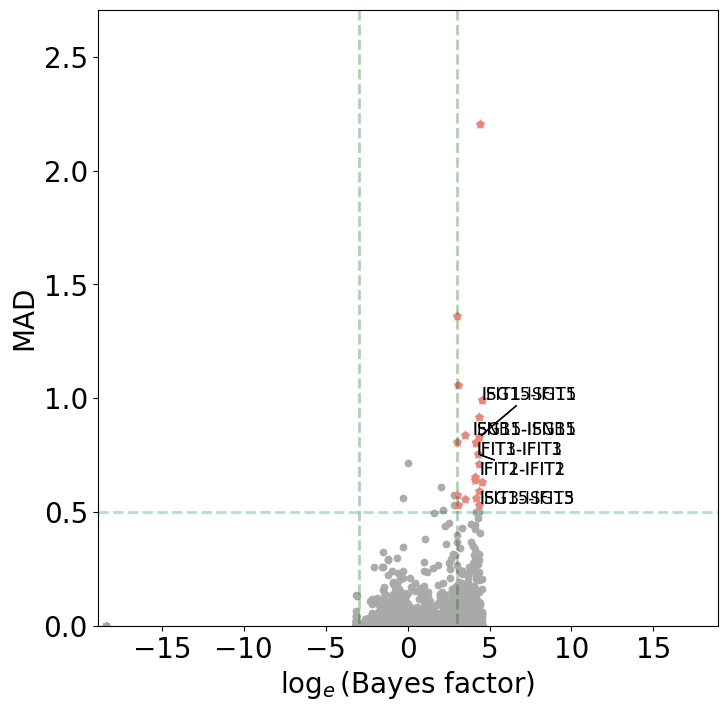

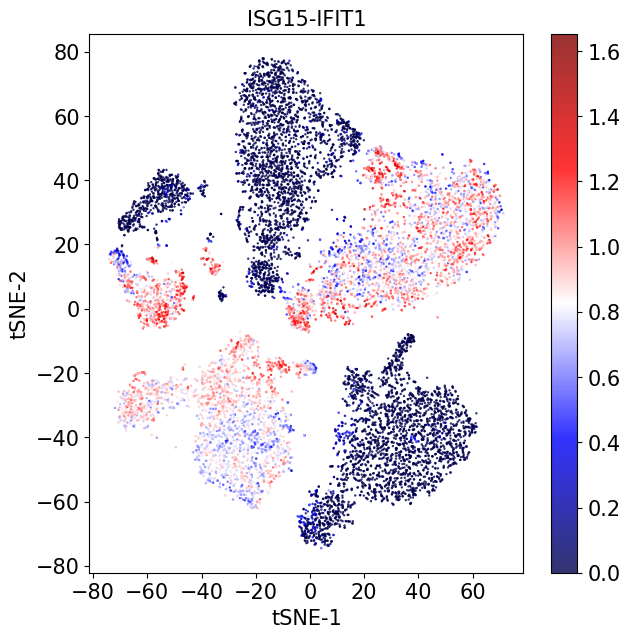

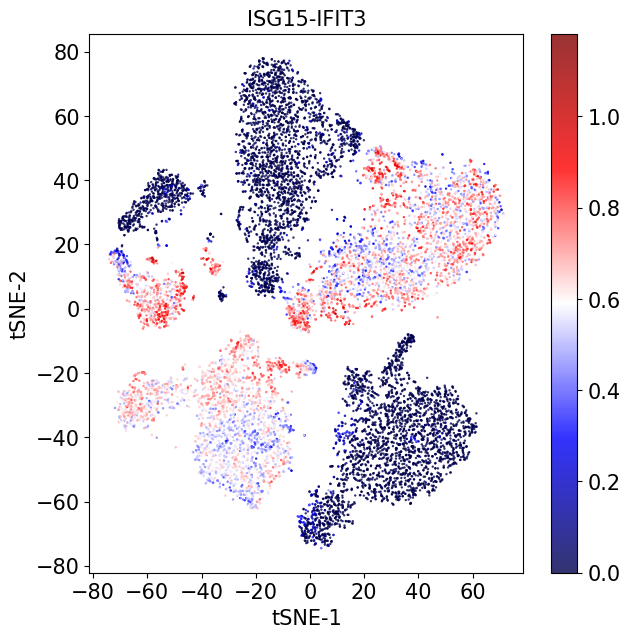

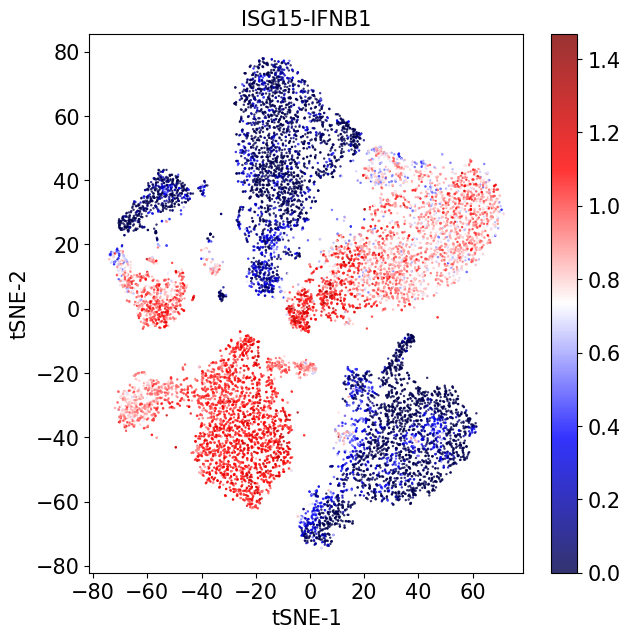

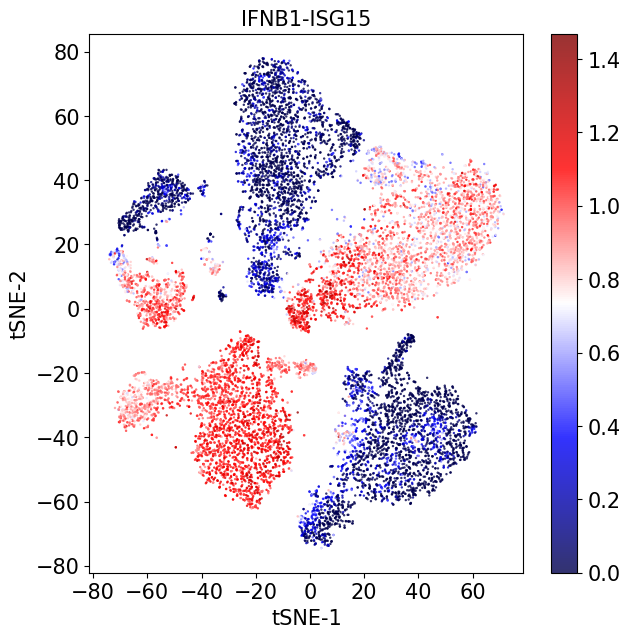

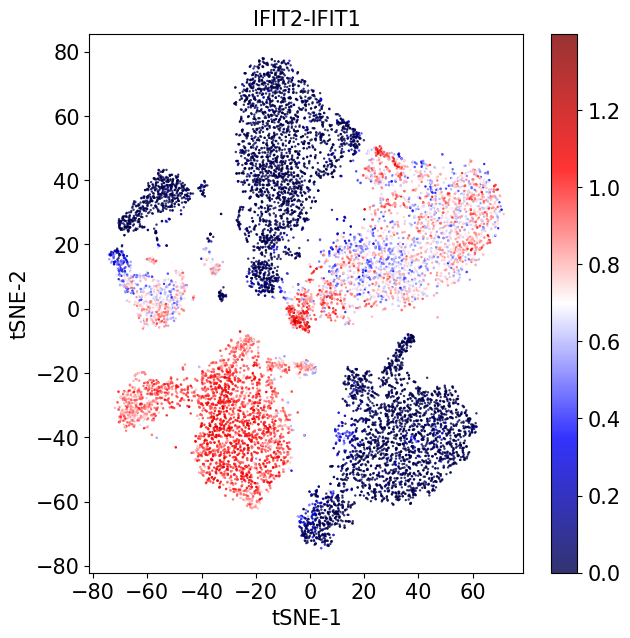

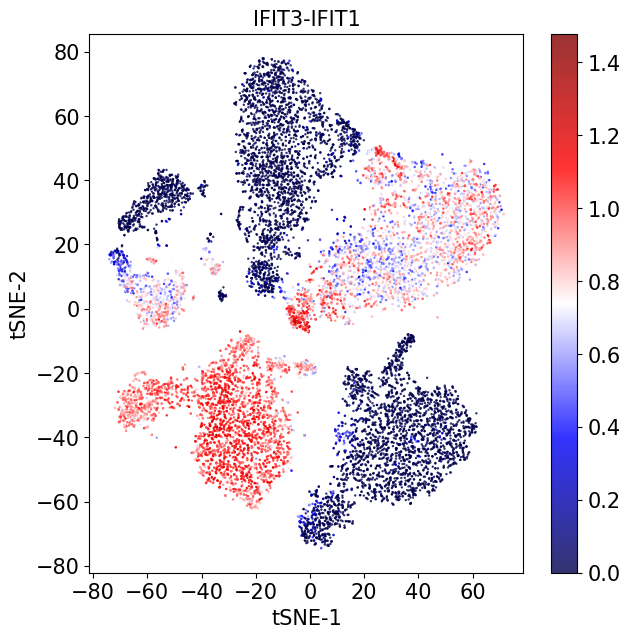

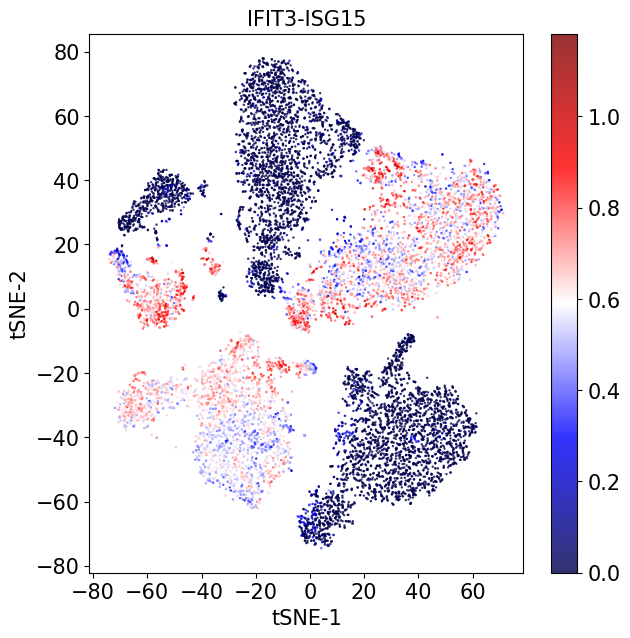

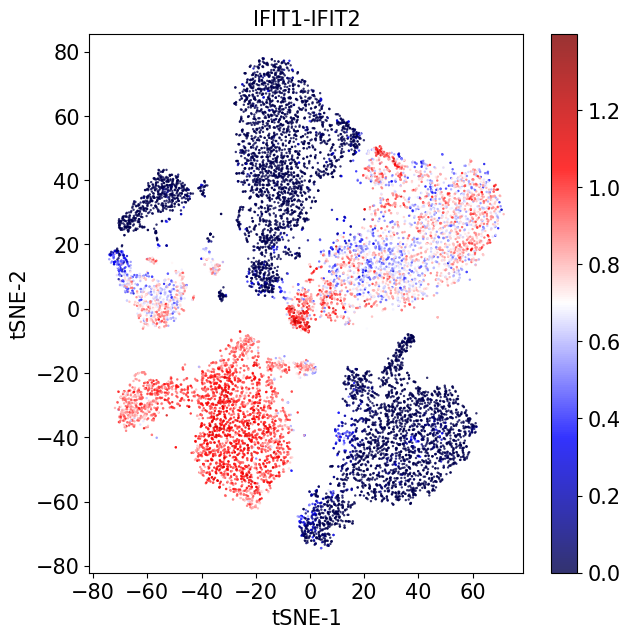

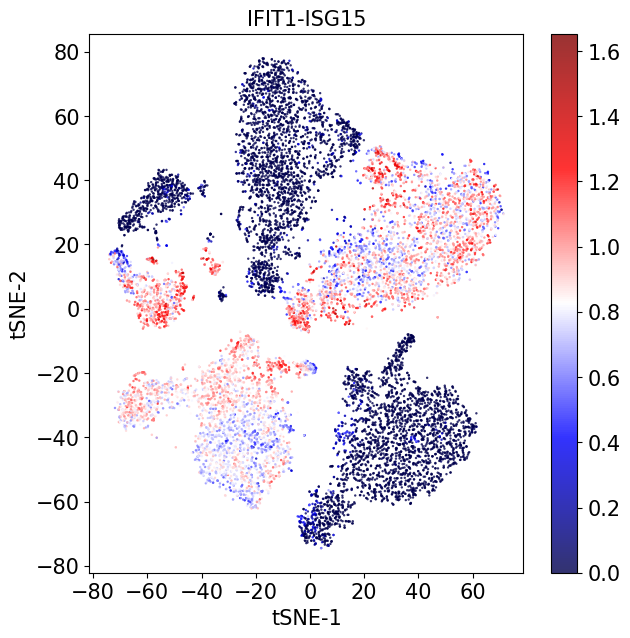

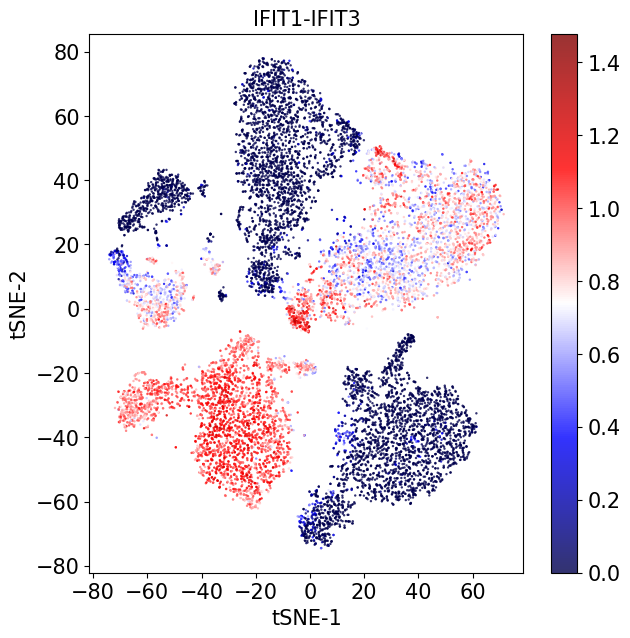

/tmp/ipykernel_109408/2651437865.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


CD14+ Monocytes
       proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
11104    0.9960    0.0040      5.517450  0.044773  0.967234  0.922461   IFIT2   
11128    0.9960    0.0040      5.517450  0.044773  0.967234  0.922461   IFIT1   
25       0.9948    0.0052      5.253881  0.140692  1.069896  0.929205   ISG15   
10073    0.9948    0.0052      5.253881  0.140692  1.069896  0.929205   IFNB1   
16927    0.9974    0.0026      5.949637  0.017023  0.983653  0.966629    CCL8   
5141     0.9974    0.0026      5.949637  0.017023  0.983653  0.966629  CXCL10   
11117    0.9960    0.0040      5.517450  0.039441  1.023050  0.983609   IFIT3   
11133    0.9960    0.0040      5.517450  0.039441  1.023050  0.983609   IFIT1   
11472    0.9976    0.0024      6.029880  0.117752  1.143780  1.026028  IFITM3   
20146    0.9976    0.0024      6.029880  0.117752  1.143780  1.026028   FFAR2   
6684     0.9962    0.0038      5.568944  0.196144  1.234344  1.038199  TRIM27   
14071    0.9

/tmp/ipykernel_109408/2651437865.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


Dendritic cells
       proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
15527    0.9940    0.0060      5.109976  0.096173  0.903801  0.807628   PIAS1   
21629    0.9940    0.0060      5.109976  0.096173  0.903801  0.807628     MX1   
25       0.9926    0.0074      4.898846  0.048099  0.863541  0.815442   ISG15   
10073    0.9926    0.0074      4.898846  0.048099  0.863541  0.815442   IFNB1   
11131    0.9948    0.0052      5.253881  0.023329  0.905113  0.881783   IFIT1   
8        0.9948    0.0052      5.253881  0.023329  0.905113  0.881783   ISG15   
5154     0.9952    0.0048      5.334326  0.015396  0.906953  0.891557  CXCL10   
20583    0.9952    0.0048      5.334326  0.015396  0.906953  0.891557    IRF3   
14087    0.9742    0.0258      3.631242  0.031914  0.947353  0.915438    OASL   
6096     0.9742    0.0258      3.631242  0.031914  0.947353  0.915438    CD14   
15529    0.9940    0.0060      5.109976  0.112449  1.056757  0.944309   PIAS1   
1046     0.9

/tmp/ipykernel_109408/2651437865.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


CD4 T cells
       proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
19       0.9864    0.0136      4.283991  0.028198  0.621437  0.593239   ISG15   
11123    0.9864    0.0136      4.283991  0.028198  0.621437  0.593239   IFIT3   
11517    0.9818    0.0182      3.987965  0.037186  0.649184  0.611998    IRF7   
12460    0.9818    0.0182      3.987965  0.037186  0.649184  0.611998    FADD   
1046     0.9758    0.0242      3.696905  0.045286  0.660610  0.615324  IFI44L   
15529    0.9758    0.0242      3.696905  0.045286  0.660610  0.615324   PIAS1   
19950    0.9606    0.0394      3.193792  0.237513  0.901997  0.664484    BST2   
18755    0.9606    0.0394      3.193792  0.237513  0.901997  0.664484     SRC   
11128    0.9778    0.0222      3.785212  0.033115  0.713067  0.679952   IFIT1   
11104    0.9778    0.0222      3.785212  0.033115  0.713067  0.679952   IFIT2   
40       0.9864    0.0136      4.283991  0.033895  0.744266  0.710370   ISG15   
5187     0.9864 

/tmp/ipykernel_109408/2651437865.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


CD8 T cells
       proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
18459    0.9704    0.0296      3.489934  0.048930  0.634571  0.585642    MAVS   
14076    0.9704    0.0296      3.489934  0.048930  0.634571  0.585642    OAS3   
19       0.9770    0.0230      3.748992  0.045899  0.639118  0.593219   ISG15   
11123    0.9770    0.0230      3.748992  0.045899  0.639118  0.593219   IFIT3   
15529    0.9666    0.0334      3.365229  0.071840  0.685816  0.613977   PIAS1   
1046     0.9666    0.0334      3.365229  0.071840  0.685816  0.613977  IFI44L   
18755    0.9642    0.0358      3.293351  0.454542  1.125556  0.671014     SRC   
19950    0.9642    0.0358      3.293351  0.454542  1.125556  0.671014    BST2   
40       0.9770    0.0230      3.748992  0.057482  0.765442  0.707959   ISG15   
5187     0.9770    0.0230      3.748992  0.057482  0.765442  0.707959   HERC5   
11128    0.9730    0.0270      3.584547  0.060200  0.777629  0.717429   IFIT1   
11104    0.9730 

/tmp/ipykernel_109408/2651437865.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


Megakaryocytes
       proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
12460    0.9970    0.0030      5.806135  0.024202  0.621752  0.597550    FADD   
11517    0.9970    0.0030      5.806135  0.024202  0.621752  0.597550    IRF7   
12713    0.9554    0.0446      3.064396  0.260207  0.862397  0.602190   NCAM1   
15708    0.9554    0.0446      3.064396  0.260207  0.862397  0.602190   ISG20   
1046     0.9882    0.0118      4.427785  0.042418  0.671631  0.629212  IFI44L   
15529    0.9882    0.0118      4.427785  0.042418  0.671631  0.629212   PIAS1   
11128    0.9994    0.0006      7.417964  0.014606  0.688178  0.673571   IFIT1   
11104    0.9994    0.0006      7.417964  0.014606  0.688178  0.673571   IFIT2   
5187     0.9978    0.0022      6.117091  0.023531  0.716359  0.692828   HERC5   
40       0.9978    0.0022      6.117091  0.023531  0.716359  0.692828   ISG15   
11117    0.9994    0.0006      7.417964  0.013417  0.727890  0.714473   IFIT3   
11133    0.99

/tmp/ipykernel_109408/2651437865.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


B cells
       proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
16422    0.9644    0.0356      3.299160  0.355492  1.032054  0.676561    IRF8   
5908     0.9644    0.0356      3.299160  0.355492  1.032054  0.676561    IRF1   
14071    0.9582    0.0418      3.132160  0.050374  0.760855  0.710481    OAS1   
6684     0.9582    0.0418      3.132160  0.050374  0.760855  0.710481  TRIM27   
5154     0.9806    0.0194      3.922891  0.020607  0.743261  0.722654  CXCL10   
20583    0.9806    0.0194      3.922891  0.020607  0.743261  0.722654    IRF3   
1046     0.9784    0.0216      3.813225  0.094648  0.819372  0.724724  IFI44L   
15529    0.9784    0.0216      3.813225  0.094648  0.819372  0.724724   PIAS1   
1684     0.9478    0.0522      2.899061  0.023081  0.763660  0.740579    XCL1   
5156     0.9478    0.0522      2.899061  0.023081  0.763660  0.740579  CXCL10   
40       0.9846    0.0154      4.157867  0.046086  0.801860  0.755774   ISG15   
5187     0.9846    0

/tmp/ipykernel_109408/2651437865.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


FCGR3A+ Monocytes
       proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
1164     0.8564    0.1436      1.785706  0.664556  1.458990  0.794434    GBP5   
1151     0.8564    0.1436      1.785706  0.664556  1.458990  0.794434    GBP1   
11104    0.9906    0.0094      4.657600  0.079526  0.888070  0.808544   IFIT2   
11128    0.9906    0.0094      4.657600  0.079526  0.888070  0.808544   IFIT1   
20146    0.9804    0.0196      3.912431  0.322544  1.164221  0.841677   FFAR2   
11472    0.9804    0.0196      3.912431  0.322544  1.164221  0.841677  IFITM3   
6684     0.9834    0.0166      4.081613  0.469679  1.321036  0.851357  TRIM27   
14071    0.9834    0.0166      4.081613  0.469679  1.321036  0.851357    OAS1   
5154     0.9942    0.0058      5.144079  0.040153  0.897529  0.857376  CXCL10   
20583    0.9942    0.0058      5.144079  0.040153  0.897529  0.857376    IRF3   
19950    0.9930    0.0070      4.954819  0.708093  1.565515  0.857421    BST2   
18755    0

/tmp/ipykernel_109408/2651437865.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
/home/iGTP2/iGTP_model_modified_scvi_sample_final_update.py:429: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_inf['cell_index']=range(len(cell_inf))


NK cells
       proba_m1  proba_m2  bayes_factor    scale1    scale2       mad  gene_1  \
12460    0.9846    0.0154      4.157867  0.086205  0.722325  0.636120    FADD   
11517    0.9846    0.0154      4.157867  0.086205  0.722325  0.636120    IRF7   
18755    0.9626    0.0374      3.247967  0.567596  1.248812  0.681215     SRC   
19950    0.9626    0.0374      3.247967  0.567596  1.248812  0.681215    BST2   
18459    0.9754    0.0246      3.680101  0.064538  0.746110  0.681572    MAVS   
14076    0.9754    0.0246      3.680101  0.064538  0.746110  0.681572    OAS3   
403      0.9156    0.0844      2.384012  0.106501  0.792501  0.686000   PTAFR   
11470    0.9156    0.0844      2.384012  0.106501  0.792501  0.686000  IFITM3   
40       0.9852    0.0148      4.198217  0.067093  0.819212  0.752119   ISG15   
5187     0.9852    0.0148      4.198217  0.067093  0.819212  0.752119   HERC5   
11128    0.9800    0.0200      3.891820  0.078576  0.899350  0.820774   IFIT1   
11104    0.9800    

In [287]:
title=args['model_prefix']+'_pbmc_ifn'+'_stimulate_tSNE'
sns.set_palette('colorblind')
fig = plt.figure(figsize=[7,7])
sns.scatterplot(x='dim_1', y='dim_2', hue='stim',data=label_df, linewidth=0, alpha=1, s=3)
plt.legend(title=title, title_fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, borderaxespad=0., fontsize=12, frameon=False, markerscale=5)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
file_name=tSNE_figure_folder+'pbmc_stimulate/'+title+'.pdf'
plt.savefig(file_name, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
    # TSNE cell type
title=args['model_prefix']+'_pbmc_ifn'+'_cell_type_tSNE'
sns.set_palette('colorblind')
fig = plt.figure(figsize=[7,7])
sns.scatterplot(x='dim_1', y='dim_2', hue='cell.type',palette='Set2', data=label_df, linewidth=0, alpha=1, s=3)
plt.legend(title=title, title_fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, borderaxespad=0., fontsize=12, frameon=False, markerscale=5)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
file_name=tSNE_figure_folder+'pbmc_cell_type/'+title+'.pdf'
plt.savefig(file_name, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
    
    # TP volcano
z_tp=z.copy()
cell_inf_df=data.obs.copy()
cell_inf_df['cell_index']=range(len(cell_inf_df))
res=model.compute_pair_bayes_factor(z_tp,cell_inf_df,'stim','cell.type','stim','ctrl',tsne_1)
TP_df_b=pd.DataFrame(res)
TP_df_b['TP_name']=TP_df['TP_name'].values
TP_df_b['TP_index']=range(len(TP_df_b))
TP_df_b.to_csv(TP_deg_folder+'whole'+'/'+args['model_prefix']+'_pbmc_ifn.csv',index=False)
print(TP_df_b.sort_values(by='mad').tail(n=30))  
temp_df=TP_df_b[abs(TP_df_b.bayes_factor)>=3]
temp_df=temp_df[temp_df['mad']>=6]
temp_df['new_tp_name']=[ i.replace('_',' ').split('%WikiPathways')[0].title() for i in temp_df['TP_name']]
string_list = ['Interferon', 'Virus']
temp_df= temp_df[temp_df['new_tp_name'].str.contains('|'.join(string_list))]
print(len(temp_df))
new_all_df_dict={}
for j in range(len(temp_df)):
    new_all_df_dict[temp_df['TP_name'].values[j]]=temp_df['new_tp_name'].values[j]
print( "TP volcano plot")


save_path=TP_deg_figure_folder+'/'+file_list[0].replace('.pkl','')+'pos.pdf'
plot_dfe(res,
         sig_lvl=3,
         pathway_list=list(TP_df_b['TP_name'].values),
         lfc_lvl=6,
         to_plot=new_all_df_dict,
         figsize=[7,8],
         s=30,
         fontsize=20,
         textsize=12,
    save=save_path)

for j in range(len(temp_df)):
    pathway_name=temp_df.TP_name.values[j]
    pathway_nu=temp_df.TP_index.values[j]
    fig = plt.figure(figsize=[7,7])
    plt.scatter(label_df['dim_1'].values, label_df['dim_2'].values, alpha = 0.8, linewidths=0,
                    c = z_tp[:,pathway_nu], marker='o', s=3, cmap ='seismic')
    plt.title(pathway_name, fontsize=15)
    cbar = plt.colorbar()
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('tSNE-1', fontsize=15)
    plt.ylabel('tSNE-2', fontsize=15)
    save_path=tSNE_figure_folder+'pbmc_pathway'+'/'+file_list[0].replace('.pkl','')+'_'+pathway_name+'tSNE'+'.pdf'
    plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

for j in cell_inf_df['cell.type'].unique():
    temp_cell_inf_df=cell_inf_df[cell_inf_df['cell.type']==j]
    temp_tsne_1=tsne_1[temp_cell_inf_df.cell_index.values,:]
    temp_z_tp=z_tp[temp_cell_inf_df.cell_index.values,:]
    temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
    res=model.compute_pair_bayes_factor(temp_z_tp,temp_cell_inf_df,'stim','cell.type','stim','ctrl',temp_tsne_1)
    TP_df_b=pd.DataFrame(res)
    TP_df_b['TP_name']=TP_df['TP_name'].values
    TP_df_b['TP_index']=range(len(TP_df_b))
    TP_df_b.to_csv(TP_deg_folder+'cell_type'+'/'+args['model_prefix']+'_'+j+'_pbmc_ifn.csv',index=False)
    print(j)
    print(TP_df_b.sort_values(by='mad').tail(n=30))  
    
    # PPI volcano 
res=model.compute_pair_bayes_factor(z_ppi,cell_inf_df,'stim','cell.type','stim','ctrl',tsne_1)
PPI_df_b=pd.DataFrame(res)
PPI_df_b['gene_1']=new_PPI_df['gene1'].values
PPI_df_b['gene_2']=new_PPI_df['gene2'].values
PPI_df_b['Interaction']=new_PPI_df['PPI'].values
PPI_df_b['PPI_index']=range(len(PPI_df_b))
#PPI_df_b[(PPI_df_b['mad']!=0)]
PPI_df_b.to_csv(PPI_deg_folder+'whole/'+args['model_prefix']+'_pbmc_ifn.csv',index=False)
print(PPI_df_b.sort_values(by='mad').tail(n=30))  
temp_df=PPI_df_b[abs(PPI_df_b.bayes_factor)>=3]
temp_df=temp_df[temp_df['mad']>=0.5]

string_list = ['IFN', 'IFIT']
temp_df= temp_df[temp_df['Interaction'].str.contains('|'.join(string_list))]
print(len(temp_df))
new_all_df_dict={}
for j in range(len(temp_df)):
    new_all_df_dict[temp_df['Interaction'].values[j]]=temp_df['Interaction'].values[j]
    # print( PPI volcano plot)


save_path=PPI_deg_figure_folder+'/'+file_list[0].replace('.pkl','')+'pos.pdf'
plot_dfe(res,
         sig_lvl=3,
         pathway_list=list(PPI_df_b['Interaction'].values),
         lfc_lvl=0.5,
         to_plot=new_all_df_dict,
         figsize=[8,8],
         s=30,
         fontsize=20,
         textsize=12,
    save=save_path)

for j in range(len(temp_df)):
    pathway_name=temp_df.Interaction.values[j]
    pathway_nu=temp_df.PPI_index.values[j]
    fig = plt.figure(figsize=[7,7])
    plt.scatter(label_df['dim_1'].values, label_df['dim_2'].values, alpha = 0.8, linewidths=0,
                c = z_ppi[:,pathway_nu], marker='o', s=3, cmap ='seismic')
    plt.title(pathway_name, fontsize=15)
    cbar = plt.colorbar()
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('tSNE-1', fontsize=15)
    plt.ylabel('tSNE-2', fontsize=15)
    save_path=tSNE_figure_folder+'pbmc_stimulate'+'/'+file_list[0].replace('.pkl','')+'_'+pathway_name+'tSNE'+'.png'
    plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

for j in cell_inf_df['cell.type'].unique():
    temp_cell_inf_df=cell_inf_df[cell_inf_df['cell.type']==j]
    temp_tsne_1=tsne_1[temp_cell_inf_df.cell_index.values,:]
    temp_z_ppi=z_ppi[temp_cell_inf_df.cell_index.values,:]
    temp_cell_inf_df['cell_index']=range(len(temp_cell_inf_df))
    res=model.compute_pair_bayes_factor(temp_z_ppi,temp_cell_inf_df,'stim','cell.type','stim','ctrl',temp_tsne_1)
    PPI_df_b=pd.DataFrame(res)
    PPI_df_b['gene_1']=new_PPI_df['gene1'].values
    PPI_df_b['gene_2']=new_PPI_df['gene2'].values
    PPI_df_b['Interaction']=new_PPI_df['PPI'].values
    PPI_df_b['PPI_index']=range(len(PPI_df_b))
    #PPI_df_b[(PPI_df_b['mad']!=0)]
    PPI_df_b.to_csv(PPI_deg_folder+'cell_type/'+args['model_prefix']+'_'+j+'_pbmc_ifn.csv',index=False)
    print(j)
    print(PPI_df_b.sort_values(by='mad').tail(n=30))
    

In [288]:
bench_mark_list=os.listdir('/home/iGTP/iGTP_data/PBMC_cell_score')
bench_mark_list=[i for i in bench_mark_list if 'h5ad' in i]
bench_mark_list=[i for i in bench_mark_list if 'Brain' not in i]
bench_mark_list.sort()
print(bench_mark_list)

['pbmc_IFN_GO_non_redundant_object.h5ad', 'pbmc_IFN_c2_object.h5ad', 'pbmc_IFN_hall_mark_object.h5ad', 'pbmc_IFN_wiki_pathways_object.h5ad']


In [290]:
temp_bench=sc.read('/home/iGTP/iGTP_data/PBMC_cell_score/'+bench_mark_list[0])

In [291]:
bench_var=temp_bench.var.copy()
bench_var['pathway_index']=range(len(bench_var))
bench_var[bench_var.features.str.contains('interferon')]

features  \
BP-type-I-interferon-production    BP-type-I-interferon-production   
BP-interferon-gamma-production      BP-interferon-gamma-production   
BP-response-to-type-I-interferon  BP-response-to-type-I-interferon   
BP-response-to-interferon-gamma    BP-response-to-interferon-gamma   
BP-response-to-interferon-alpha    BP-response-to-interferon-alpha   
BP-response-to-interferon-beta      BP-response-to-interferon-beta   

                                  pathway_index  
BP-type-I-interferon-production             367  
BP-interferon-gamma-production              368  
BP-response-to-type-I-interferon            401  
BP-response-to-interferon-gamma             402  
BP-response-to-interferon-alpha             425  
BP-response-to-interferon-beta              426

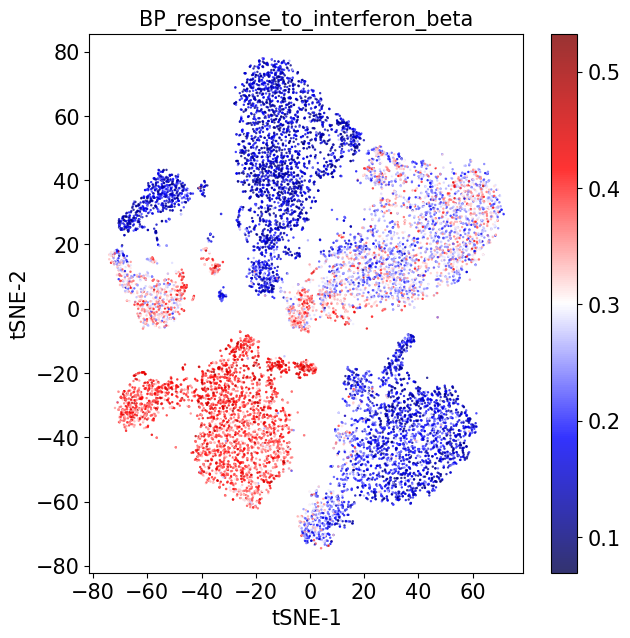

In [293]:
fig = plt.figure(figsize=[7,7])
plt.scatter(label_df['dim_1'].values, label_df['dim_2'].values, alpha = 0.8, linewidths=0,
                    c = temp_bench.X.A[:,426], marker='o', s=3, cmap ='seismic')
pathway_name='BP_response_to_interferon_beta'
plt.title(pathway_name, fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
save_path=tSNE_figure_folder+bench_mark_list[0].replace('..h5ad','')+'_'+'BP_response_to_interferon_beta'+'tSNE'+'.pdf'
plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [301]:
from matplotlib.lines import Line2D

In [ ]:
GO_merged_PC_homo_v11mse_pos_uniform_15000batch_B cells_pbmc_ifn.csv

In [303]:
cell_list=['CD14+ Monocytes', 'Dendritic cells', 'CD4 T cells', 'CD8 T cells', 'B cells', 'FCGR3A+ Monocytes', 'NK cells']
deg_file_list=['GO_merged_PC_homo_v11mse_pos_uniform_15000batch_CD14+ Monocytes_pbmc_ifn.csv',
 'GO_merged_PC_homo_v11mse_pos_uniform_15000batch_Dendritic cells_pbmc_ifn.csv',
 'GO_merged_PC_homo_v11mse_pos_uniform_15000batch_CD4 T cells_pbmc_ifn.csv',
 'GO_merged_PC_homo_v11mse_pos_uniform_15000batch_CD8 T cells_pbmc_ifn.csv',
 'GO_merged_PC_homo_v11mse_pos_uniform_15000batch_B cells_pbmc_ifn.csv',
 'GO_merged_PC_homo_v11mse_pos_uniform_15000batch_FCGR3A+ Monocytes_pbmc_ifn.csv',
 'GO_merged_PC_homo_v11mse_pos_uniform_15000batch_NK cells_pbmc_ifn.csv']

In [305]:
gesa_table=pd.read_csv('/home/iGTP/fig_2_result/cluster.all.STIM_vs_CTRL_gse.tsv',sep='\t')
gesa_table=gesa_table[gesa_table['p.adjust']<=0.05]
int_path=TP_df[TP_df.TP_name.isin(gesa_table.Description)]['TP_name'].values
print(len(int_path))
int_path

72


array(['BP_negative_regulation_of_cytokine_production',
       'BP_epithelial_cell_development', 'BP_cytoplasmic_translation',
       'BP_neutrophil_mediated_immunity',
       'BP_regulation_of_immune_effector_process',
       'BP_RNA_catabolic_process', 'BP_translational_initiation',
       'BP_protein_targeting', 'BP_response_to_virus',
       'BP_response_to_fungus',
       'BP_posttranscriptional_regulation_of_gene_expression',
       'BP_carbohydrate_biosynthetic_process',
       'BP_rRNA_metabolic_process', 'BP_peptidyl_cysteine_modification',
       'BP_viral_life_cycle', 'BP_second_messenger_mediated_signaling',
       'BP_ribonucleoprotein_complex_biogenesis',
       'BP_positive_regulation_of_defense_response',
       'BP_type_I_interferon_production',
       'BP_regulation_of_cellular_amide_metabolic_process',
       'BP_cell_junction_organization',
       'BP_response_to_type_I_interferon',
       'BP_response_to_interferon_gamma', 'BP_ncRNA_processing',
       'BP_response

In [313]:
draw_table_2

TP_name  setSize       NES  bayes_factor  \
2                      BP_response_to_virus       82  2.258796      3.688469   
7            BP_response_to_interferon_beta       16  1.882818      3.429044   
37  BP_regulation_of_innate_immune_response       71  1.560414      3.157417   

          mad   dot_sizes  
2   16.143032  172.956204  
7   11.447634   30.839416  
37  10.116083  149.270073

/tmp/ipykernel_109408/1571113904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_table_1['positive_ind']=draw_table_1['NES']*draw_table_1['bayes_factor']


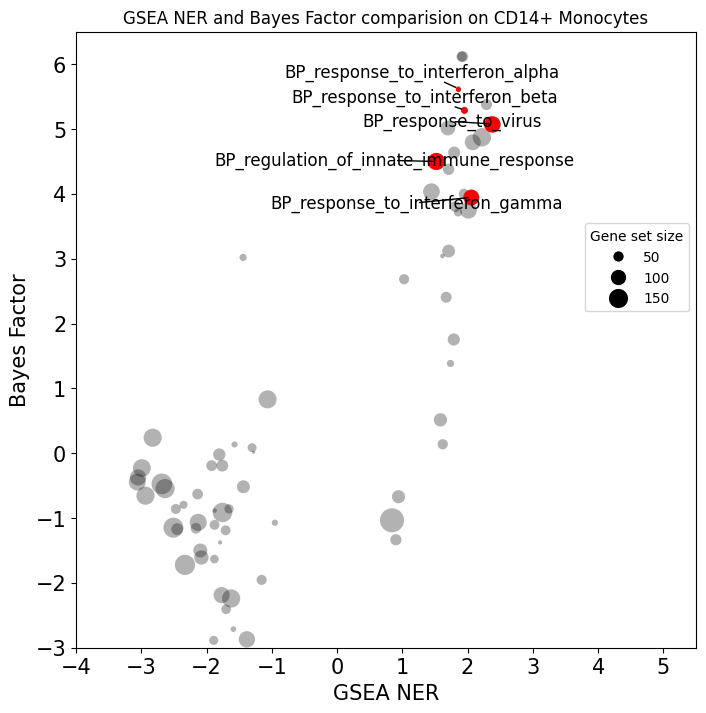

/tmp/ipykernel_109408/1571113904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_table_1['positive_ind']=draw_table_1['NES']*draw_table_1['bayes_factor']


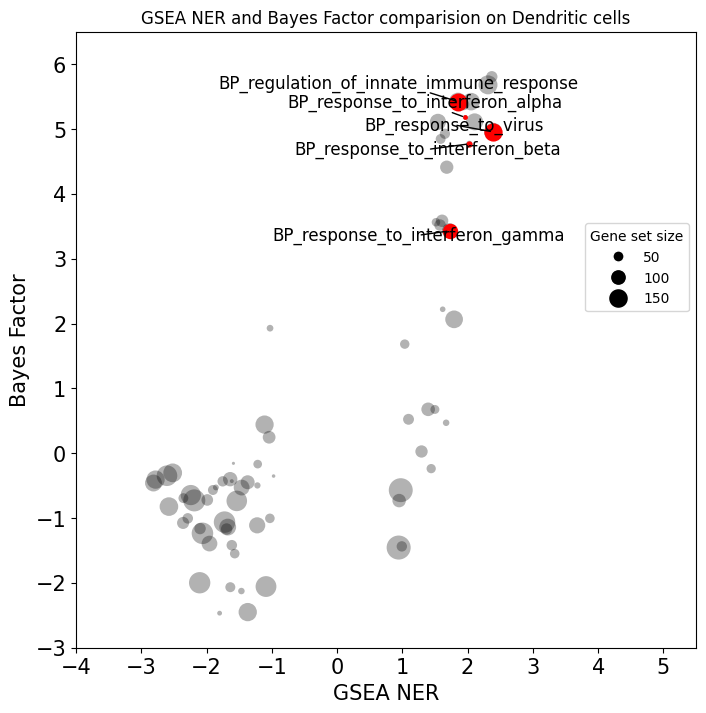

/tmp/ipykernel_109408/1571113904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_table_1['positive_ind']=draw_table_1['NES']*draw_table_1['bayes_factor']


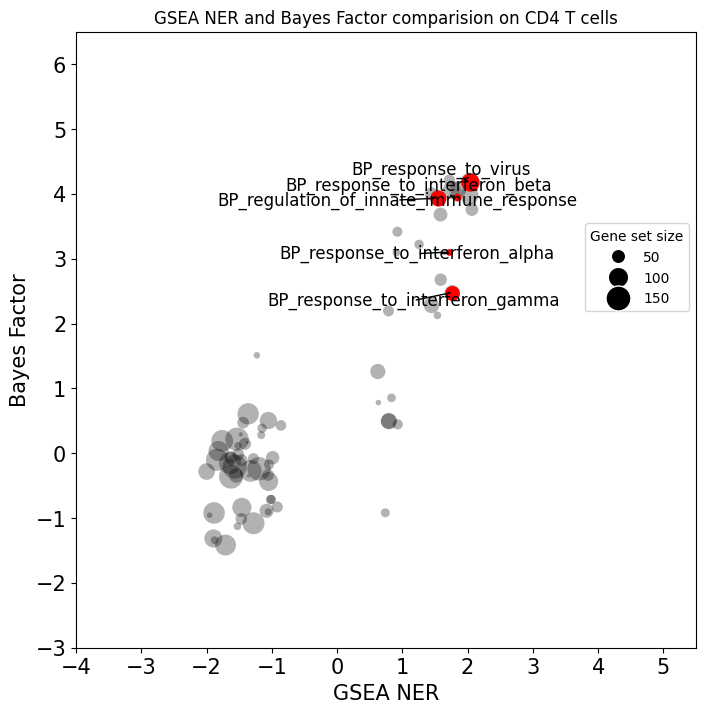

/tmp/ipykernel_109408/1571113904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_table_1['positive_ind']=draw_table_1['NES']*draw_table_1['bayes_factor']


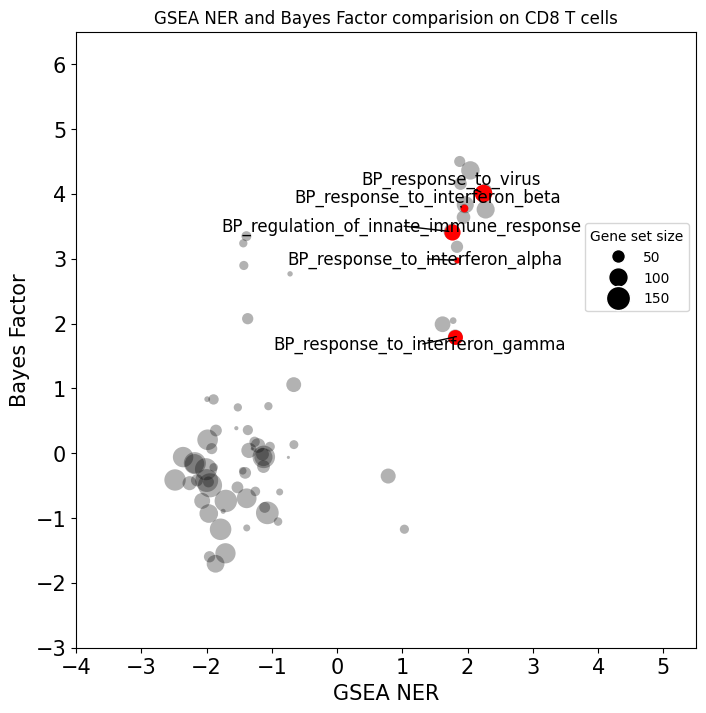

/tmp/ipykernel_109408/1571113904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_table_1['positive_ind']=draw_table_1['NES']*draw_table_1['bayes_factor']


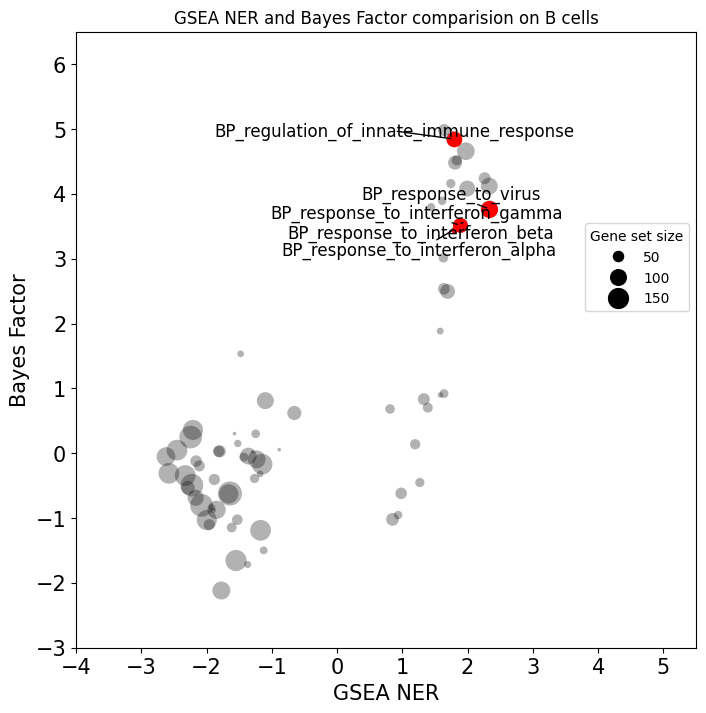

/tmp/ipykernel_109408/1571113904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_table_1['positive_ind']=draw_table_1['NES']*draw_table_1['bayes_factor']


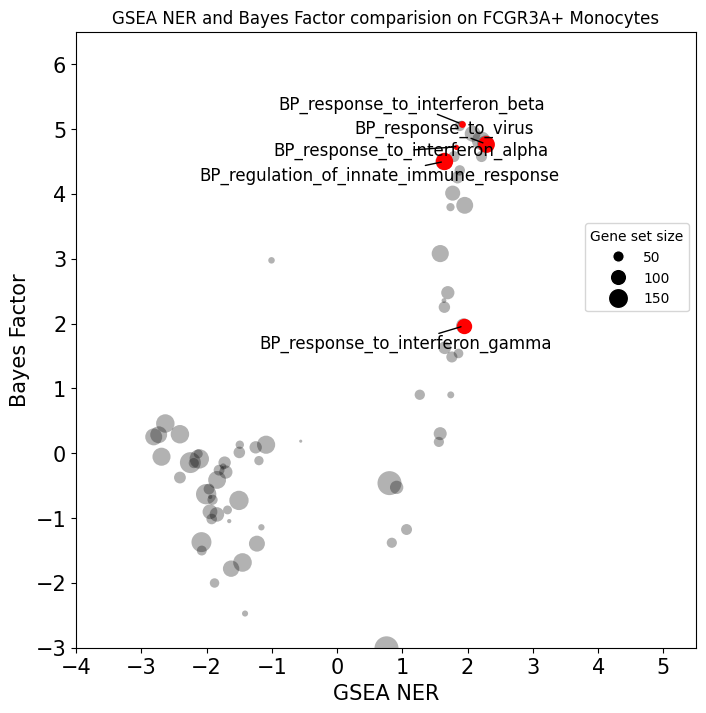

/tmp/ipykernel_109408/1571113904.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  draw_table_1['positive_ind']=draw_table_1['NES']*draw_table_1['bayes_factor']


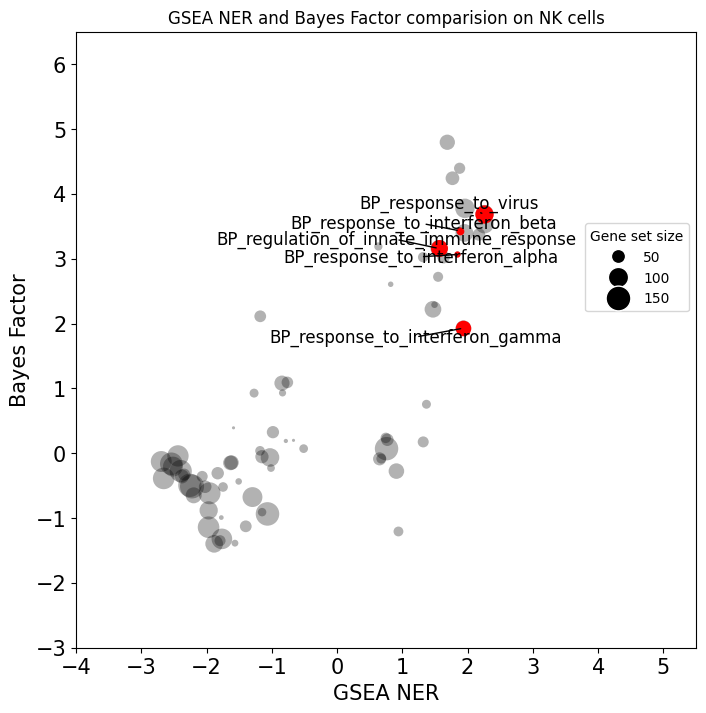

In [352]:
gesa_table=pd.read_csv('/home/iGTP/fig_2_result/cluster.all.STIM_vs_CTRL_gse.tsv',sep='\t')
for i in range(len(cell_list)):
    temp_deg=pd.read_csv('./fig_2_result/TP_deg/cell_type/'+deg_file_list[i])
    temp_deg=temp_deg[['TP_name','bayes_factor','mad']]
    
    gesa_table_1=gesa_table[gesa_table.cell_type==cell_list[i]]
    gesa_table_1=gesa_table_1[gesa_table_1.Description.isin(int_path)]
    gesa_table_1=gesa_table_1[['Description','setSize','NES']]
    gesa_table_1.columns=['TP_name','setSize','NES']
    #print(len(gesa_table_1))
    draw_table=gesa_table_1.merge(temp_deg)
    draw_table_1=draw_table[(draw_table.NES>0)&(draw_table.bayes_factor>0)]
    draw_table_1['positive_ind']=draw_table_1['NES']*draw_table_1['bayes_factor']
    draw_table_1=draw_table_1.sort_values(by='positive_ind',ascending=False)
    #print(len(draw_table))
    p_sizes=draw_table.setSize.values
    a,b = 5,300
    dot_sizes = a + ((p_sizes - np.min(p_sizes))*(b-a))/(np.max(p_sizes)-np.min(p_sizes))
    draw_table['dot_sizes']=dot_sizes
    draw_table_2=draw_table[(draw_table.TP_name.str.contains('response_to_virus'))|(draw_table.TP_name.str.contains('BP_response_to_interferon'))|(draw_table.TP_name.str.contains('BP_regulation_of_innate_immune_response'))]
    fig = plt.figure(figsize=[8,8])
    plt.scatter(draw_table['NES'], draw_table['bayes_factor'], s=draw_table['dot_sizes'], c='k', linewidth=0, alpha=0.3)
    texts = []
    interest_points = [(x, y) for x, y in zip(draw_table_2['NES'], draw_table_2['bayes_factor'])]
    for j in range(len(draw_table_2)):
        texts.append(plt.text(x=draw_table_2['NES'].values[j], y=draw_table_2['bayes_factor'].values[j],s=draw_table_2['TP_name'].values[j], fontdict={'size':12}))
        plt.scatter(draw_table_2['NES'].values[j],draw_table_2['bayes_factor'].values[j], s=draw_table_2['dot_sizes'].values[j], c='r', linewidth=0)
    adjust_text(texts, only_move={'text':'xy', 'arrows':'xy' ,'static':'xy', 'explode':'xy', 'pull':'xy'}, arrowprops=dict(arrowstyle="-", color='k', lw=1))

    plt.xlabel(r'GSEA NER', fontsize=15)
    plt.ylabel(r'Bayes Factor', fontsize=15)
    plt.xticks(np.arange(-4, 5.5, step=1),fontsize=15)
    plt.yticks(np.arange(-3, 6.5, step=1),fontsize=15)
    plt.ylim(-3,6.5)
    plt.xlim(-4,5.5)

    legend_sizes = a + ((np.array([50,100,150]) - np.min(p_sizes))*(b-a))/(np.max(p_sizes)-np.min(p_sizes))
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(50), markerfacecolor='k', markersize=np.sqrt(legend_sizes[0])),
                   Line2D([0], [0], marker='o', color='w', label=str(100), markerfacecolor='k', markersize=np.sqrt(legend_sizes[1])),
                   Line2D([0], [0], marker='o', color='w', label=str(150), markerfacecolor='k', markersize=np.sqrt(legend_sizes[2]))]

    save_path='./fig_2_result/GESA_compare'+'/all_csv/'+deg_file_list[i].replace('.csv','_all.csv')
    draw_table['ind']=draw_table['NES']*draw_table['bayes_factor']
    draw_table=draw_table.sort_values(by=['mad','ind'],ascending=False)
    draw_table[['TP_name',  'NES', 'bayes_factor','ind','mad']].to_csv(save_path,index=False)
    save_path='./fig_2_result/GESA_compare'+'/'+deg_file_list[i].replace('.csv','pos.csv')
    draw_table_1.to_csv(save_path,index=False)
    plt.legend(handles=legend_elements, title='Gene set size', loc='best', bbox_to_anchor=[1, 0.7])
    plt.title('GSEA NER and Bayes Factor comparision on ' + cell_list[i])
    save_path='./fig_2_result/GESA_compare'+'/'+deg_file_list[i].replace('.csv','')+'_.pdf'
    plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [354]:
z.shape

(13672, 1296)

In [ ]:
gene_1_index

In [ ]:
tsne_1 = TSNE(n_components=2, random_state=42).fit_transform(z)
label_df=data.obs.reset_index()
label_df['dim_1']=tsne_1[:,0]
label_df['dim_2']=tsne_1[:,1]

In [ ]:
z_ppi=[]
for i in tqdm(range(len(new_PPI_df))):
    gene_1_index=new_PPI_df.gene_1_index.values[i]
    gene_2_index=new_PPI_df.gene_2_index.values[i]
    specific_sites1= [(gene_1_index, gene_2_index)]
    specific_sites2= [(gene_2_index, gene_1_index)]
    mask1 = np.zeros_like(gene_weight, dtype=bool)
    for site in specific_sites1:
        mask1[site] = True
    gene_weight1 = np.where(mask1, gene_weight, 0)

    mask2 = np.zeros_like(gene_weight, dtype=bool)
    for site in specific_sites2:
        mask2[site] = True
    gene_weight2 = np.where(mask2, gene_weight, 0)
    value1= np.sum(np.matmul(ppi, gene_weight1.T),axis=1)
    value2= np.sum(np.matmul(ppi, gene_weight2.T),axis=1)
    temp_df=pd.DataFrame(label_df['index'].values,columns=['cell'])
    temp_df['value1']=value1
    temp_df['value2']=value2
    temp_df['final_value']=np.where(temp_df['value1']>temp_df['value2'],temp_df['value1'],temp_df['value2'])
    z_ppi.append(temp_df['final_value'].values)
z_ppi=np.array(z_ppi)

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
from functools import partial
from tqdm import tqdm

In [ ]:
chunk=np.array_split(new_PPI_df, 20)[0]
for i, row in tqdm(chunk.iterrows()):
    print(row)

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
from functools import partial
from tqdm import tqdm

# Function to process each chunk of the DataFrame in parallel
def process_chunk(chunk, gene_weight, label_df):
    for i, row in tqdm(chunk.iterrows()):
        gene_1_index = row['gene_1_index']
        gene_2_index = row['gene_2_index']
        PPI=row['PPI']
        specific_sites1 = [(gene_1_index, gene_2_index)]
        specific_sites2 = [(gene_2_index, gene_1_index)]
        mask1 = np.zeros_like(gene_weight, dtype=bool)
        for site in specific_sites1:
            mask1[site] = True
        gene_weight1 = np.where(mask1, gene_weight, 0)

        mask2 = np.zeros_like(gene_weight, dtype=bool)
        for site in specific_sites2:
            mask2[site] = True
        gene_weight2 = np.where(mask2, gene_weight, 0)
        value1 = np.sum(np.matmul(ppi, gene_weight1.T), axis=1)
        value2 = np.sum(np.matmul(ppi, gene_weight2.T), axis=1)
        temp_df = pd.DataFrame(label_df['index'].values, columns=['cell'])
        temp_df['value1'] = value1
        temp_df['value2'] = value2
        temp_df[PPI] = np.where(temp_df['value1'] > temp_df['value2'], temp_df['value1'], temp_df['value2'])
        temp_df=temp_df[['cell',PPI]]
    return temp_df

# Function to parallel process DataFrame chunks
def parallel_process(df, func, num_processes, gene_weight, label_df):
    chunks = np.array_split(df, num_processes)  # Split DataFrame into chunks
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(partial(func, gene_weight=gene_weight, label_df=label_df), chunks)
    return pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)

# Sample data

# Number of parallel processes to use
num_processes = 40

# Parallel processing
processed_df = parallel_process(new_PPI_df, process_chunk, num_processes, gene_weight, label_df)

print(processed_df.head())



In [ ]:
specific_sites1= [(5367, 9382)]
specific_sites2= [(9382, 5367)]
mask1 = np.zeros_like(gene_weight, dtype=bool)
for site in specific_sites1:
    mask1[site] = True
gene_weight1 = np.where(mask1, gene_weight, 0)

mask2 = np.zeros_like(gene_weight, dtype=bool)
for site in specific_sites2:
    mask2[site] = True
gene_weight2 = np.where(mask2, gene_weight, 0)

In [ ]:
gene_weight1.shape

In [ ]:
import numpy as np 

In [ ]:
value1= np.sum(np.matmul(ppi, gene_weight1.T),axis=1)
value2= np.sum(np.matmul(ppi, gene_weight2.T),axis=1)

In [356]:
label_df

index     orig.ident  nCount_RNA  nFeature_RNA    label  \
0      AAACATACATTTCC-1_1  SeuratProject      3018.0           878  control   
1      AAACATACCAGAAA-1_1  SeuratProject      2481.0           713  control   
2      AAACATACCTCGCT-1_1  SeuratProject      3420.0           850  control   
3      AAACATACCTGGTA-1_1  SeuratProject      3158.0          1111  control   
4      AAACATACGATGAA-1_1  SeuratProject      1869.0           635  control   
...                   ...            ...         ...           ...      ...   
13667  TTTGCATGAACGAA-1_2  SeuratProject      5578.0          1238     case   
13668  TTTGCATGACGTAC-1_2  SeuratProject      1364.0           536     case   
13669  TTTGCATGCCTGTC-1_2  SeuratProject      2116.0           819     case   
13670  TTTGCATGCTAAGC-1_2  SeuratProject      1522.0           523     case   
13671  TTTGCATGGGACGA-1_2  SeuratProject      1143.0           503     case   

           tsne1      tsne2   ind  stim  clusters        cell.type multiplets  \
0     -27.640373  14.966629  1016  ctrl         9  CD14+ Monocytes    singlet   
1     -27.493646  28.924885  1256  ctrl         9  CD14+ Monocytes    singlet   
2     -24.367997  20.429285  1256  ctrl         9  CD14+ Monocytes    singlet   
3      27.952170  24.159738  1039  ctrl         4  Dendritic cells    singlet   
4      -0.470236 -25.398709  1488  ctrl         5      CD4 T cells    singlet   
...          ...        ...   ...   ...       ...              ...        ...   
13667  -2.421106  28.893534  1244  stim         8  CD14+ Monocytes    singlet   
13668  18.747179   1.919201  1488  stim         6      CD4 T cells    singlet   
13669 -11.563067   2.574095  1256  stim         4          B cells    singlet   
13670  25.142392   6.603815   107  stim         6      CD4 T cells    singlet   
13671  14.359657  10.965601  1488  stim         6      CD4 T cells    singlet   

       percent.mt  n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
0        0.099404      878                877        3017.0              0.0   
1        0.241838      713                713        2481.0              0.0   
2        0.087719      850                850        3420.0              0.0   
3        0.063331     1111               1110        3157.0              0.0   
4        0.053505      635                635        1869.0              0.0   
...           ...      ...                ...           ...              ...   
13667    0.089638     1238               1238        5578.0              0.0   
13668    0.439883      536                536        1364.0              0.0   
13669    0.047259      819                819        2116.0              0.0   
13670    0.000000      523                523        1522.0              0.0   
13671    0.000000      503                503        1143.0              0.0   

       pct_counts_mt      dim_1      dim_2  
0                0.0  17.641476 -51.108845  
1                0.0  38.913776 -55.918583  
2                0.0  20.533020 -51.821098  
3                0.0 -30.919445   3.848443  
4                0.0 -10.160151  43.954601  
...              ...        ...        ...  
13667            0.0  -7.721248 -18.330801  
13668            0.0  52.290462   7.816011  
13669            0.0 -51.116840   8.763008  
13670            0.0  38.743347   8.934555  
13671            0.0  56.974056  24.450974  

[13672 rows x 20 columns]

In [ ]:
label_df['value1']=value1
label_df['value2']=value2

In [ ]:
label_df['final_value']=np.where(label_df['value1']>label_df['value2'],label_df['value1'],label_df['value2'])

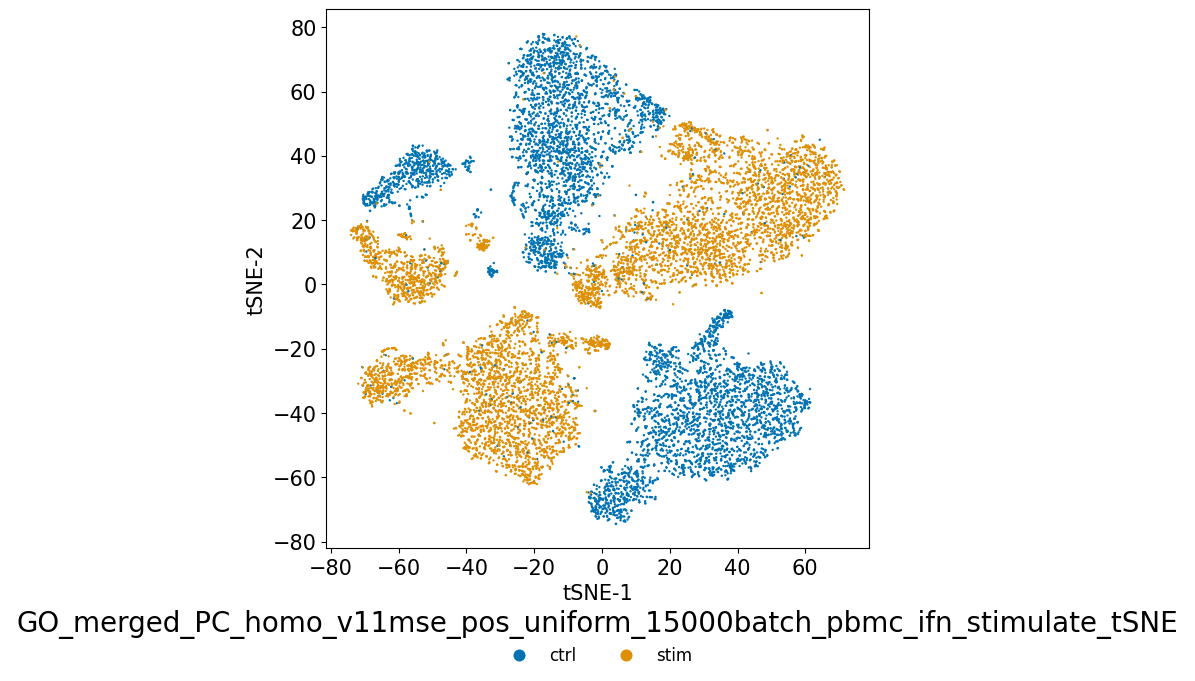

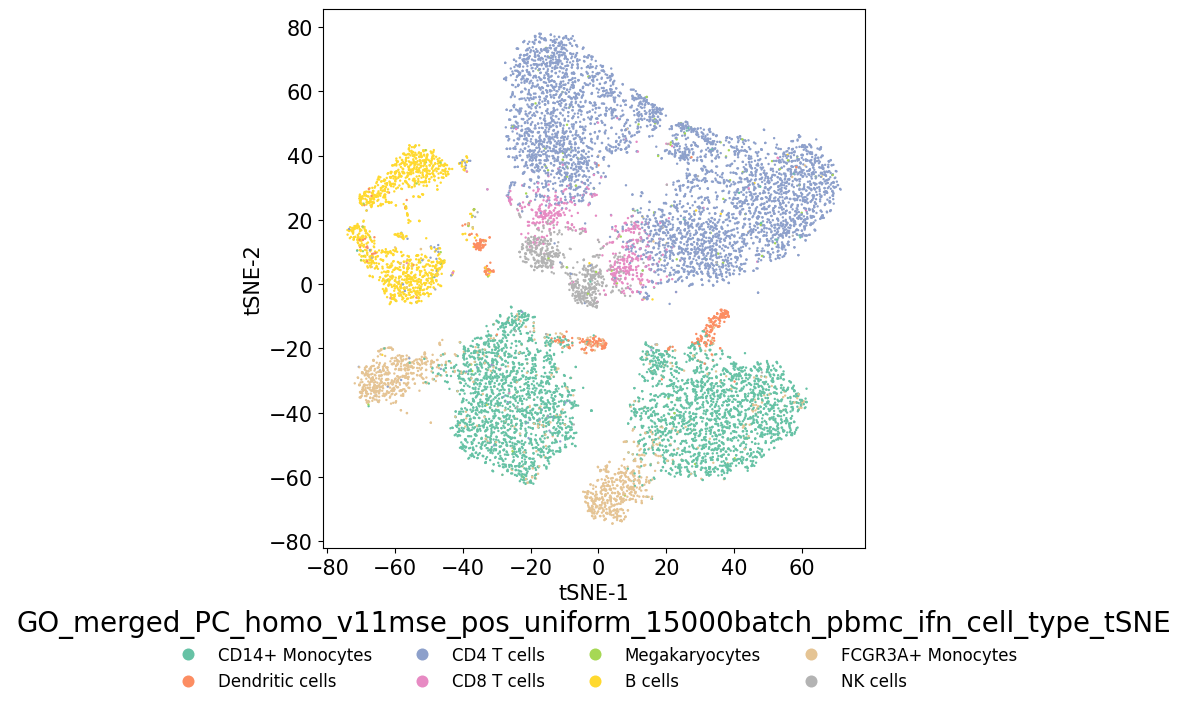

In [72]:
title=args['model_prefix']+'_pbmc_ifn'+'_stimulate_tSNE'
sns.set_palette('colorblind')
fig = plt.figure(figsize=[7,7])
sns.scatterplot(x='dim_1', y='dim_2', hue='stim',data=label_df, linewidth=0, alpha=1, s=3)
plt.legend(title=title, title_fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, borderaxespad=0., fontsize=12, frameon=False, markerscale=5)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#file_name=tSNE_figure_folder+'pbmc_stimulate/'+title+'.pdf'
#plt.savefig(file_name, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
    # TSNE cell type
title=args['model_prefix']+'_pbmc_ifn'+'_cell_type_tSNE'
sns.set_palette('colorblind')
fig = plt.figure(figsize=[7,7])
sns.scatterplot(x='dim_1', y='dim_2', hue='cell.type',palette='Set2', data=label_df, linewidth=0, alpha=1, s=3)
plt.legend(title=title, title_fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, borderaxespad=0., fontsize=12, frameon=False, markerscale=5)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#file_name=tSNE_figure_folder+'pbmc_cell_type/'+title+'.pdf'
#plt.savefig(file_name, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
pathway_name='IFNAR1-PRKD2'
#pathway_nu=temp_df.TP_index.values[j]
fig = plt.figure(figsize=[7,7])
plt.scatter(label_df['dim_1'].values, label_df['dim_2'].values, alpha = 0.8, linewidths=0,
                    c = label_df['value1'], marker='o', s=3, cmap ='seismic')
plt.title(pathway_name, fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.show()
plt.close()

In [ ]:
label_df['value2']

In [ ]:
pathway_name='IFNAR1-PRKD2'
#pathway_nu=temp_df.TP_index.values[j]
fig = plt.figure(figsize=[7,7])
plt.scatter(label_df['dim_1'].values, label_df['dim_2'].values, alpha = 0.8, linewidths=0,
                    c = label_df['value2'], marker='o', s=3, cmap ='seismic')
plt.title(pathway_name, fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.show()
plt.close()

In [ ]:
pathway_name='GATA3-TBX21'
#pathway_nu=temp_df.TP_index.values[j]
fig = plt.figure(figsize=[7,7])
plt.scatter(label_df['dim_1'].values, label_df['dim_2'].values, alpha = 0.8, linewidths=0,
                    c = label_df['final_value'], marker='o', s=3, cmap ='seismic')
plt.title(pathway_name, fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.show()
plt.close()

In [ ]:
value1=

In [ ]:
saved_state_dict['decoder_Gene_Gene.0.weight'].cpu().detach().numpy()[9859,10298]

In [ ]:
for i in saved_state_dict['decoder_Gene_Gene.0.weight'].cpu().detach().numpy()[10298]:
    print(i)

In [ ]:
output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)

In [ ]:
tsne_1 = TSNE(n_components=2, random_state=42).fit_transform(z)
label_df=data.obs.reset_index()
label_df['dim_1']=tsne_1[:,0]
label_df['dim_2']=tsne_1[:,1]

In [ ]:
q_ppi=PPI_df[PPI_df.gene1=='IFNAR1']

In [ ]:
file_list

In [ ]:
mask_list_dict['Gene_Gene_mask'].shape

In [ ]:
PPI_df[PPI_df.gene1=='IFNAR1']

In [ ]:
task_file

In [ ]:
task_file_path='./save_model/pbmc_IFN_filtered/processed_data/'+file_list[0]
with open(task_file_path, 'rb') as file:
    task_file = pickle.load(file)
args=task_file['args']
data_x_s=task_file['data_x_s']
mask_list_dict=task_file['mask_dict']
data=task_file['data']
TP_df=task_file['TP_df']
PPI_df=task_file['ppi_df_1']
    # encode Z, Z_TP, Z_PPI

model=iGTP(args,mask_list_dict)
saved_state_dict = torch.load(args['model_dir']+model_list[0],map_location="cpu")
model.load_state_dict(saved_state_dict)
model.eval()
with torch.no_grad():
    z=model.encode_z(torch.tensor(data_x_s).float())

In [ ]:
model(torch.tensor(data_x_s).float())

In [ ]:
temp_csv=pd.read_csv('/home/iGTP/fig_2_result/sscrna_benchmark.csv')

In [ ]:
temp_csv['TP_set'].unique()

In [ ]:
temp_csv[(temp_csv['TP_set']=='GO')&(temp_csv['cell_type']=='all')]['spearmean'].mean()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_1 = TSNE(n_components=2, random_state=42).fit_transform(z)
label_df=data.obs.reset_index()
label_df['dim_1']=tsne_1[:,0]
label_df['dim_2']=tsne_1[:,1]

In [ ]:

#label_df.to_csv(tSNE_folder+args['model_prefix']+'_pbmc_ifn.csv',index=False)
    # TSNE stimulate
title=args['model_prefix']+'_pbmc_ifn'+'_stimulate_tSNE'
sns.set_palette('colorblind')
fig = plt.figure(figsize=[7,7])
sns.scatterplot(x='dim_1', y='dim_2', hue='stim',data=label_df, linewidth=0, alpha=1, s=3)
plt.legend(title=title, title_fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, borderaxespad=0., fontsize=12, frameon=False, markerscale=5)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#file_name=tSNE_figure_folder+'pbmc_stimulate/'+title+'.pdf'
#plt.savefig(file_name, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
    # TSNE cell type
title=args['model_prefix']+'_pbmc_ifn'+'_cell_type_tSNE'
sns.set_palette('colorblind')
fig = plt.figure(figsize=[7,7])
sns.scatterplot(x='dim_1', y='dim_2', hue='cell.type',palette='Set2', data=label_df, linewidth=0, alpha=1, s=3)
plt.legend(title=title, title_fontsize=20, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, borderaxespad=0., fontsize=12, frameon=False, markerscale=5)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#file_name=tSNE_figure_folder+'pbmc_cell_type/'+title+'.pdf'
#plt.savefig(file_name, format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

pathway_name='BP_regulation_of_vesicle_mediated_transport	'
#pathway_nu=temp_df.TP_index.values[j]
fig = plt.figure(figsize=[7,7])
plt.scatter(label_df['dim_1'].values, label_df['dim_2'].values, alpha = 0.8, linewidths=0,
                    c = z[:,399], marker='o', s=3, cmap ='seismic')
plt.title(pathway_name, fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('tSNE-1', fontsize=15)
plt.ylabel('tSNE-2', fontsize=15)
plt.show()
plt.close()

In [ ]:
356	0.516689
355	BP_response_to_interferon_gamma	402	[STXBP2, GBP2, MEFV, STAT1, IFITM3, TRIM8, FCG...	357	0.720997
377	BP_response_to_interferon_alpha	425	[IFITM1, IFITM3, TPR, EIF2AK2, IFIT3, MX2, KLH...	379	0.629392
378	BP_response_to_interferon_beta	426	[STAT1, HTRA2, TREX1, IFITM1, IFITM3, CAPN2, N...	380	

In [ ]:
bench_mark_list=os.listdir('/home/iGTP/iGTP_data/PBMC_cell_score')
bench_mark_list=[i for i in bench_mark_list if 'h5ad' in i]
bench_mark_list=[i for i in bench_mark_list if 'Brain' not in i]
bench_mark_list.sort()
print(bench_mark_list)

In [ ]:
temp_bench=sc.read('/home/iGTP/iGTP_data/PBMC_cell_score/'+bench_mark_list[0])

In [ ]:
TP_df

In [ ]:
bench_var=temp_bench.var.copy()
bench_var['pathway_index']=range(len(bench_var))
bench_var=bench_var.reset_index()
bench_var=bench_var[['features','pathway_index']]
bench_var['features']=[i.replace('-','_') for i in bench_var['features'] ]
bench_var=bench_var[['features','pathway_index']]
bench_var.columns=['TP_name','SSGESA_index']

In [ ]:
all_tp=bench_var.merge(TP_df)

In [ ]:
ssgesa_c=temp_bench.obs.copy().reset_index()[['index','cell.type']]
ssgesa_c['sgesa_index']=range(len(ssgesa_c))


In [ ]:
ssgesa_p=temp_bench.X.A

In [ ]:
iGTP_c=data.obs.copy().reset_index()[['index','cell.type']]
iGTP_c['igtp_index']=range(len(iGTP_c))


In [ ]:
ssgesa_c.merge(iGTP_c)

In [ ]:
from scipy.stats import spearmanr,pearsonr

In [ ]:
all_tp

In [ ]:
all_sp=[]
for i in range(len(all_tp)):
    s_index=all_tp.SSGESA_index.values[i]
    i_index=all_tp.TP_index.values[i]
    temp_bench_tp_emb=ssgesa_p[:,s_index]
    temp_iGTP_TP_emb=z[:,i_index]
    res = spearmanr(temp_bench_tp_emb, temp_iGTP_TP_emb)
    all_sp.append(res[0])

In [ ]:
all_tp['spear_c']=all_sp

In [ ]:
all_tp[all_tp.spear_c>0]

In [ ]:
all_tp[all_tp.spear_c<=0]

In [ ]:
all_tp.spear_c.mean()

In [ ]:
all_tp.spear_c.std()

In [ ]:
all_tp[all_tp.spear_c>0]['spear_c'].mean()

In [ ]:
all_tp[all_tp.spear_c<=0]['spear_c'].mean()

In [ ]:
all_tp.sort_values(by='spear_c',ascending=False).head(n=50)

In [ ]:
all_tp.sort_values(by='spear_c',ascending=False).tail(n=10)

In [ ]:
all_tp.spear_c.mean()

In [ ]:
all_tp.spear_c.std()

In [ ]:
all_tp[all_tp.TP_name.str.contains('interferon')]

In [ ]:
cell_inf_df

In [ ]:
z.shape

In [ ]:
label_df

In [ ]:
cell_inf_df=data.obs.copy()
cell_inf_df['cell_index']=range(len(cell_inf_df))
res=model.compute_pair_bayes_factor(z,cell_inf_df,'stim','cell.type','stim','ctrl',tsne_1)
TP_df_b=pd.DataFrame(res)
TP_df_b['TP_name']=TP_df['TP_name'].values
TP_df_b['TP_index']=range(len(TP_df_b))

In [ ]:
TP_df_b_mean=TP_df_b['bayes_factor'].mean()
TP_df_b_std=TP_df_b['bayes_factor'].std()

In [ ]:
TP_df_b_std

In [ ]:
TP_df_b_mean

In [ ]:
TP_df_b_std

In [ ]:
TP_df_b['abs_b']=abs(TP_df_b.bayes_factor)
TP_df_b=TP_df_b.sort_values(by='abs_b',ascending=False)

In [ ]:
TP_df_b

In [ ]:
select_tp=TP_df_b['TP_name'].values[0:50]

In [ ]:
all_tp[all_tp.TP_name.isin(select_tp)].sort_values(by='spear_c')

In [ ]:
all_tp[all_tp.TP_name.isin(select_tp)].sort_values(by='spear_c')['spear_c'].mean()

In [ ]:
all_tp[all_tp.TP_name.isin(select_tp)].sort_values(by='spear_c')['spear_c'].std()